NOTE: This jupyter notebook is intended for review purposes for the corresponding CHI 2025 submission titled: `SocialEyes: Scaling mobile eye-tracking to multi-person social settings`

The cells utilise methods and data processed by the SocialEyes modules. 

In [1]:
import os, glob, shutil
import re
import cv2
import json
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib import cm 
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import linear_model
from scipy.spatial import ConvexHull
from tqdm.notebook import tqdm, trange
from itertools import combinations
from datetime import timedelta
from utils import *
import datetime
import warnings
warnings.filterwarnings(action='ignore')
DATA_PATH = "####"
medium_palette = {
    "film": "#7A003C", 
    "performance": "#FDBF57"
}
# groups_palette = {
#     "day1_film": '#7A003C',
#     "day1_perf": '#DB9D35',
#     "day2_perf": '#FDBF57',
#     "day2_film": '#9C005E'
# }

groups_palette = {'day1_film': '#c7295a',
 'day1_perf': '#DB9D35',
 'day2_perf': '#ac8700',
 'day2_film': '#600331'}

## Recording infos

In [11]:
#Load info dataframe
infos_df = pd.read_csv(os.path.join(DATA_PATH, "recordings_info.csv"))
infos_df.shape #shape[0] is the total number of recordings

(120, 21)

In [12]:
infos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   android_device_id     120 non-null    object 
 1   android_device_model  120 non-null    object 
 2   android_device_name   120 non-null    object 
 3   app_version           120 non-null    object 
 4   calib_version         120 non-null    int64  
 5   data_format_version   120 non-null    float64
 6   duration              120 non-null    int64  
 7   firmware_version      120 non-null    object 
 8   frame_id              120 non-null    int64  
 9   frame_name            120 non-null    object 
 10  gaze_frequency        120 non-null    int64  
 11  gaze_offset           120 non-null    object 
 12  module_serial_number  120 non-null    int64  
 13  os_version            120 non-null    int64  
 14  pipeline_version      120 non-null    object 
 15  recording_id          1

## Event timestamps

In [9]:
events_df = pd.read_csv("raw_video_markers.csv")

def convert_to_timedelta(alex_timestamp):
    if pd.isnull(alex_timestamp):
        return np.nan
    hh, mm, ss, ms = map(int, alex_timestamp.split(':'))
    delta = timedelta(hours=hh, minutes=mm, seconds=ss, milliseconds=ms*10)
    return delta

#make all timestamps relative to performance_start and use performance_start ltz timestamps for each day to convert time
for day in range(1,3):
    performance_start_alex_ts = convert_to_timedelta(events_df[events_df["Label"] == "Performers_Going_To_Stage"][f"Day{day}_VideoTimecode"].iloc[0])
    events_df[f"Day{day}_VideoTimecode_ltz"] = events_df[f"Day{day}_VideoTimecode"].apply(convert_to_timedelta) - performance_start_alex_ts + event_timestamps[f"day{day}"]["performance"]["start"] 

In [10]:
events_df

Unnamed: 0  No                         Label       Medium        Detail  \
0            0   1             AVRecording_Start          NaN         Start   
1            1   2                   Event_Start          NaN         Start   
2            2   3                  Sizzle_Start         Film        Sizzle   
3            3   4                    Sizzle_End         Film        Sizzle   
4            4   5      First_Introduction_Start         Talk         Intro   
5            5   6        First_Introduction_End         Talk         Intro   
6            6   7     Performers_Going_To_Stage  Performance           NaN   
7            7   8               01_Prolog_Start  Performance       Tableau   
8            8   9                 01_Prolog_End  Performance       Tableau   
9            9  10                02_Marse_Start  Performance       Tableau   
10          10  11                  02_Marse_End  Performance       Tableau   
11          11  12            03_Intro-Rap_Start  Performance       Tableau   
12          12  13              03_Intro-Rap_End  Performance       Tableau   
13          13  14           04_Exposition_Start  Performance       Tableau   
14          14  15             04_Exposition_End  Performance       Tableau   
15          15  16        05_Interrogation_Start  Performance       Tableau   
16          16  17          05_Interrogation_End  Performance       Tableau   
17          17  18        06_Justice-Truth_Start  Performance       Tableau   
18          18  19          06_Justice-Truth_End  Performance       Tableau   
19          19  20  07_CognitiveDissonance_Start  Performance       Tableau   
20          20  21    07_CognitiveDissonance_End  Performance       Tableau   
21          21  22            08_MbiraSong_Start  Performance       Tableau   
22          22  23              08_MbiraSong_End  Performance       Tableau   
23          23  24         09_Litany-Rocks_Start  Performance       Tableau   
24          24  25           09_Litany-Rocks_End  Performance       Tableau   
25          25  26         10_Lineup-Canjo_Start  Performance       Tableau   
26          26  27           10_Lineup-Canjo_End  Performance       Tableau   
27          27  28    11_PodRattleIncident_Start  Performance       Tableau   
28          28  29      11_PodRattleIncident_End  Performance       Tableau   
29          29  30             12_Meantime_Start  Performance       Tableau   
30          30  31               12_Meantime_End  Performance       Tableau   
31          31  32               13_IAmJax_Start  Performance       Tableau   
32          32  33                 13_IAmJax_End  Performance       Tableau   
33          33  34           14_BehindBars_Start  Performance       Tableau   
34          34  35             14_BehindBars_End  Performance       Tableau   
35          35  36           15_Time-Truth_Start  Performance       Tableau   
36          36  37             15_Time-Truth_End  Performance       Tableau   
37          37  38          16_TearingItUp_Start  Performance       Tableau   
38          38  39            16_TearingItUp_End  Performance       Tableau   
39          39  40   17_Survivors-Postlude_Start  Performance       Tableau   
40          40  41     17_Survivors-Postlude_End  Performance       Tableau   
41          41  42   Intermission_Briefing_Start         Talk  Intermission   
42          42  43    Intermisssion_Briefing_End         Talk  Intermission   
43          43  44                    Film_Start         Film     Innocents   
44          44  45                      Film_End         Film     Innocents   
45          45  46                     Event_End          NaN           End   
46          46  46      Video_Calibration_Target          NaN   Calibration   
47          47  46                     Clapper_1          NaN   Calibration   
48          48  46                     Clapper_2          NaN   Calibration   
49          49  46                     Clapper_3      

In [ ]:
# events_df.to_csv("raw_video_markers.csv")

## Offsets

In [11]:
offset_files = glob.glob(os.path.join(DATA_PATH, "EventDay?/Eyes/Logs/*_offsets.csv"))
day1_offsets, day2_offsets = pd.DataFrame(), pd.DataFrame()
#concat all time_offset files for each day
for f in offset_files:
    df = pd.read_csv(f)
    if "EventDay1" in f:
        day1_offsets = pd.concat([day1_offsets, df], ignore_index=True)
    elif "EventDay2" in f:
        day2_offsets = pd.concat([day2_offsets, df], ignore_index=True)
    else:
        raise Exception("Incorrect path detected")

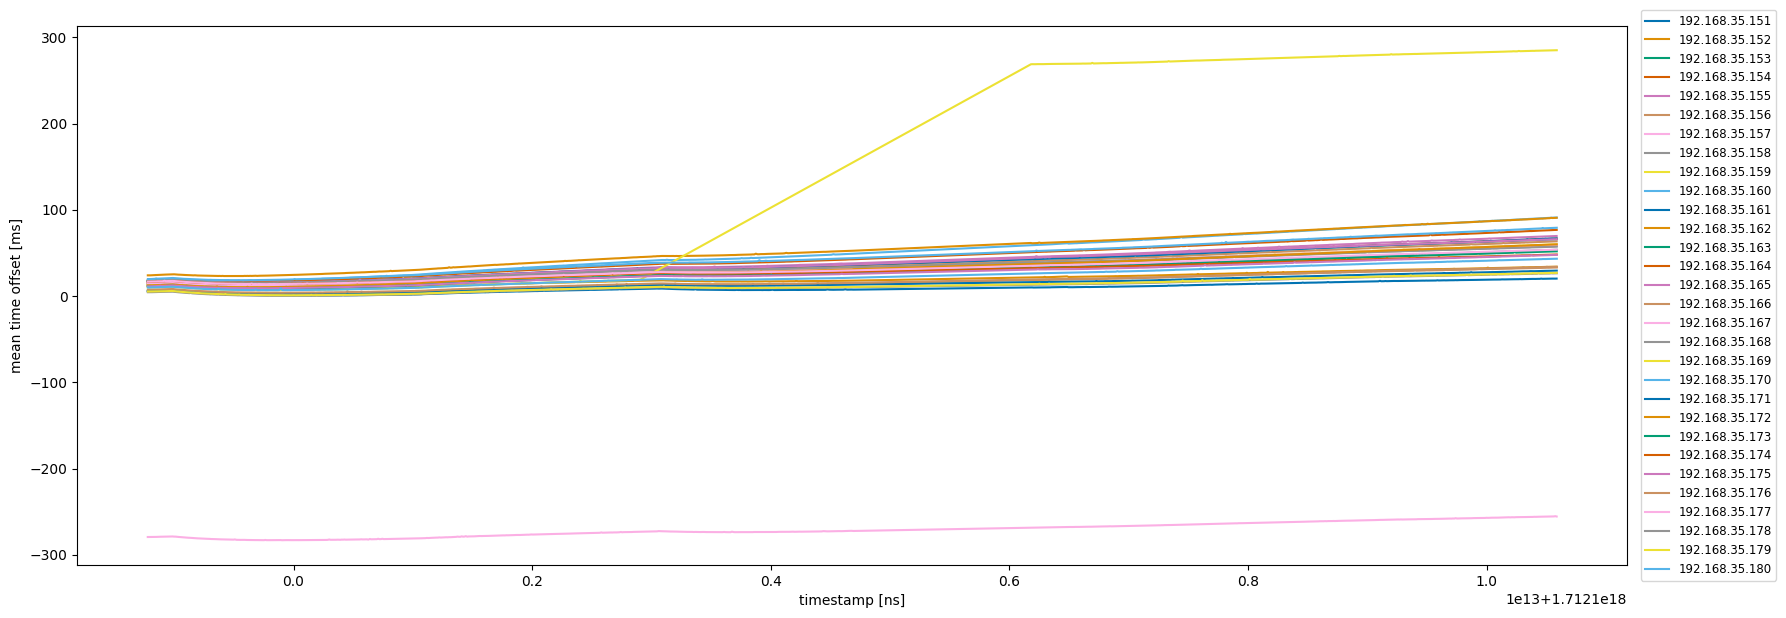

In [12]:
plt.figure(figsize=(20,7))
plot = sns.lineplot(day1_offsets, x="timestamp [ns]", y="mean time offset [ms]", hue = "device", palette="colorblind")
plot.legend(fontsize=8.5, loc="right", bbox_to_anchor=(1.1, 0.5))

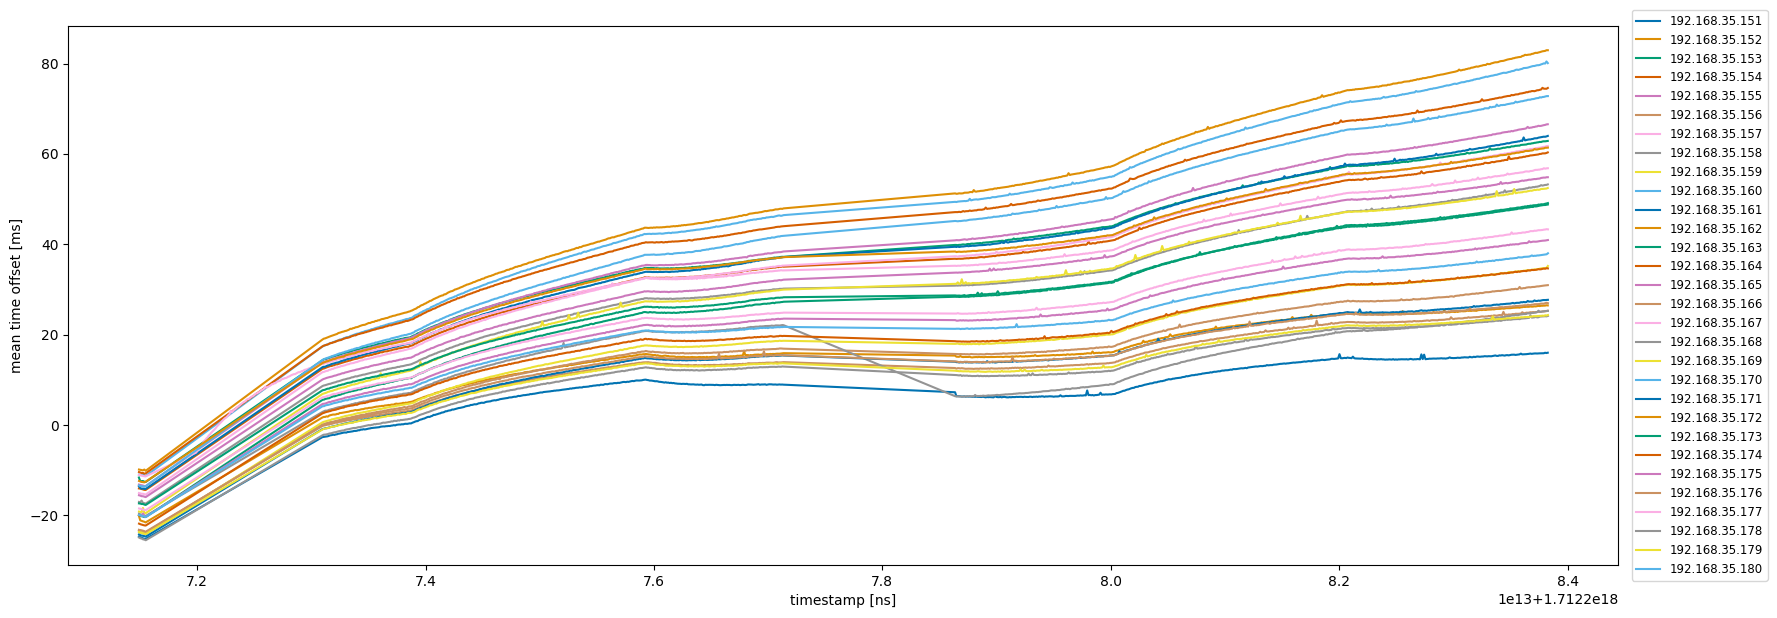

In [13]:
plt.figure(figsize=(20,7))
plot = sns.lineplot(day2_offsets, x="timestamp [ns]", y="mean time offset [ms]", hue = "device", palette="colorblind")
plot.legend(fontsize=8.5, loc="right", bbox_to_anchor=(1.1, 0.5))

In [16]:
day1_offsets["timestamp [local time]"] = pd.to_datetime(day1_offsets["timestamp [ns]"], unit="ns", utc=True)
day2_offsets["timestamp [local time]"] = pd.to_datetime(day2_offsets["timestamp [ns]"], unit="ns", utc=True)

In [17]:
offsets_film_day1 = day1_offsets[(day1_offsets["timestamp [local time]"] > event_timestamps["day1"]["film"]["start"]) & (day1_offsets["timestamp [local time]"] < event_timestamps["day1"]["film"]["end"])]
offsets_perf_day1 = day1_offsets[(day1_offsets["timestamp [local time]"] > event_timestamps["day1"]["performance"]["start"]) & (day1_offsets["timestamp [local time]"] < event_timestamps["day1"]["performance"]["end"])]
offsets_film_day2 = day2_offsets[(day2_offsets["timestamp [local time]"] > event_timestamps["day2"]["film"]["start"]) & (day2_offsets["timestamp [local time]"] < event_timestamps["day2"]["film"]["end"])]
offsets_perf_day2 = day2_offsets[(day2_offsets["timestamp [local time]"] > event_timestamps["day2"]["performance"]["start"]) & (day2_offsets["timestamp [local time]"] < event_timestamps["day2"]["performance"]["end"])]

stats for offsets

In [18]:
df1 = offsets_film_day1.groupby("device").mean()[["mean time offset [ms]", "mean roundtrip duration [ms]"]]
df2 = offsets_perf_day1.groupby("device").mean()[["mean time offset [ms]", "mean roundtrip duration [ms]"]]
df3 = offsets_film_day2.groupby("device").mean()[["mean time offset [ms]", "mean roundtrip duration [ms]"]]
df4 = offsets_perf_day2.groupby("device").mean()[["mean time offset [ms]", "mean roundtrip duration [ms]"]]
concat_df = df1.join(df2, lsuffix="day1_film", rsuffix= "day1_perf").join(df3.join(df4, lsuffix="day2_film", rsuffix= "day2_perf"))

In [1086]:
print(concat_df.at["192.168.35.157", "mean time offset [ms]day1_film"],
      concat_df.at["192.168.35.157", "mean time offset [ms]day1_perf"],
      concat_df.at["192.168.35.169", "mean time offset [ms]day1_perf"])

-277.4263060686016 -261.38903536977494 277.294308681672


In [1087]:
concat_df.at["192.168.35.157", "mean time offset [ms]day1_film"] = np.nan
concat_df.at["192.168.35.157", "mean time offset [ms]day1_perf"] = np.nan
concat_df.at["192.168.35.169", "mean time offset [ms]day1_perf"] = np.nan

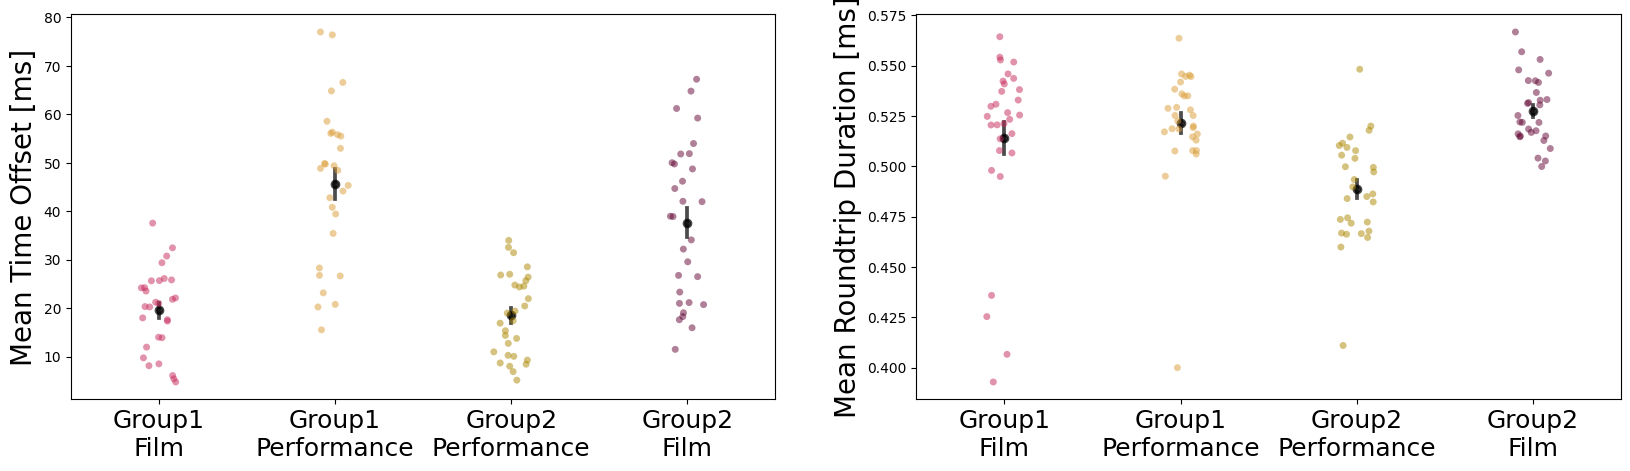

In [1088]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
labels = ["Group1\nFilm", "Group1\nPerformance", "Group2\nPerformance", "Group2\nFilm"]

measures = ['mean time offset [ms]day1_film', 'mean time offset [ms]day1_perf',
           'mean time offset [ms]day2_perf', 'mean time offset [ms]day2_film']
sns.stripplot(
    data=concat_df[[c for c in concat_df.columns if c.startswith("mean time offset")]],
    alpha=.5, legend=False, order = measures, ax = axs[0], palette = {k:groups_palette[k.split("[ms]")[1]] for k in measures}
)
sns.pointplot(
    data=concat_df[[c for c in concat_df.columns if c.startswith("mean time offset")]], 
    linestyle="none", errorbar="se",
    marker=".", markersize=10, markeredgewidth=2, color="black", alpha = 0.7, 
    order = measures, ax=axs[0]
)

measures = ['mean roundtrip duration [ms]day1_film', 'mean roundtrip duration [ms]day1_perf',
            'mean roundtrip duration [ms]day2_perf', 'mean roundtrip duration [ms]day2_film']
sns.stripplot(
    data=concat_df[[c for c in concat_df.columns if c.startswith("mean roundtrip duration ")]],
    alpha=.5, legend=False, order = measures, ax=axs[1], palette = {k:groups_palette[k.split("[ms]")[1]] for k in measures}
)
sns.pointplot(
    data=concat_df[[c for c in concat_df.columns if c.startswith("mean roundtrip duration")]], 
    linestyle="none", errorbar="se",
    marker=".", markersize=10, markeredgewidth=2, color="black", alpha = 0.7, 
    order = measures, ax=axs[1]
)
axs[0].set_xticklabels(labels, fontsize=18)
axs[1].set_xticklabels(labels, fontsize=18)
# axes[0].set_title('Mean Roundtrip Duration ')
# axes[1].set_xlabel('Conditions')
axs[0].set_ylabel('Mean Time Offset [ms]', fontsize=20)
axs[1].set_ylabel('Mean Roundtrip Duration [ms]', fontsize=20)
plt.savefig("plt_dumps/offsets_stat.png", dpi=300, bbox_inches='tight')

In [125]:
concat_df.describe()

mean time offset [ms]day1_film  mean roundtrip duration [ms]day1_film  \
count                       29.000000                              30.000000   
mean                        19.581326                               0.514193   
std                          8.504955                               0.043154   
min                          4.781240                               0.392929   
25%                         13.917731                               0.509294   
50%                         20.976781                               0.525132   
75%                         25.655145                               0.540219   
max                         37.558918                               0.564354   

       mean time offset [ms]day1_perf  mean roundtrip duration [ms]day1_perf  \
count                       28.000000                              30.000000   
mean                        45.568509                               0.521707   
std                         16.458177                               0.027482   
min                         15.543569                               0.400032   
25%                         33.649285                               0.515016   
50%                         48.651399                               0.523859   
75%                         55.877363                               0.535764   
max                         76.998457                               0.563601   

       mean time offset [ms]day2_film  mean roundtrip duration [ms]day2_film  \
count                       30.000000                              30.000000   
mean                        37.647447                               0.527567   
std                         16.141713                               0.016758   
min                         11.513301                               0.499927   
25%                         21.704939                               0.515348   
50%                         38.950257                               0.523643   
75%                         49.958918                               0.540416   
max                         67.246259                               0.566724   

       mean time offset [ms]day2_perf  mean roundtrip duration [ms]day2_perf  
count                       30.000000                              30.000000  
mean                        18.518220                               0.488739  
std                          8.457873                               0.025653  
min                          5.158451                               0.411044  
25%                         10.458678                               0.471919  
50%                         18.209495                               0.488047  
75%                         25.449091                               0.507247  
max                         33.995152                               0.548215

Plot drift for each device

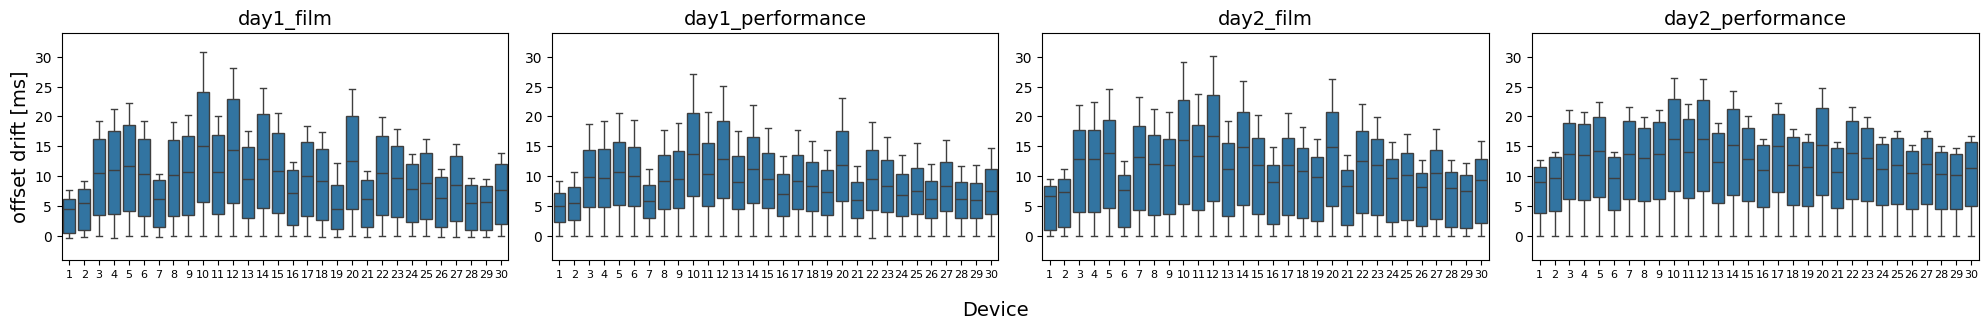

In [494]:
fig,axs = plt.subplots(1,4, figsize=(20, 3))
for i,(cond, df) in enumerate({"day1_film": offsets_film_day1,
                           "day1_performance": offsets_perf_day1, 
                           "day2_film": offsets_film_day2, 
                           "day2_performance": offsets_perf_day2}.items()):
    init_value = df.groupby("device")["mean time offset [ms]"].transform("first")
    df['drift'] = df['mean time offset [ms]'] - init_value
    df = df.sort_values("device")
    sns.boxplot(df, y="drift", x="device", ax=axs[i], showfliers=False)
    axs[i].set_ylim(-4,34)
    axs[i].set_xticklabels([int(ip_.split(".")[-1])-150 for ip_ in df.device.unique()], fontsize=8)
    axs[i].set_ylabel("offset drift [ms]" if i==0 else '', fontsize=14)
    axs[i].set_title(cond, fontsize=14)
    axs[i].set_xlabel("")
fig.text(0.5, -0.05, 'Device', ha='center', va='center', fontsize=14)
# plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
# plt.savefig("plt_dumps/offsets.png")

In [837]:
concat_df = pd.DataFrame()
for cond, df in {"day1_film": offsets_film_day1,
                           "day1_perf": offsets_perf_day1,  
                           "day2_perf": offsets_perf_day2,
                           "day2_film": offsets_film_day2,}.items():
    init_value = df.groupby("device")["mean time offset [ms]"].transform("first")
    df['drift'] = df['mean time offset [ms]'] - init_value
    df = df[["device", "drift"]]
    df["condition"] = cond
    concat_df = pd.concat([concat_df, df.sort_values("device")], ignore_index=True)

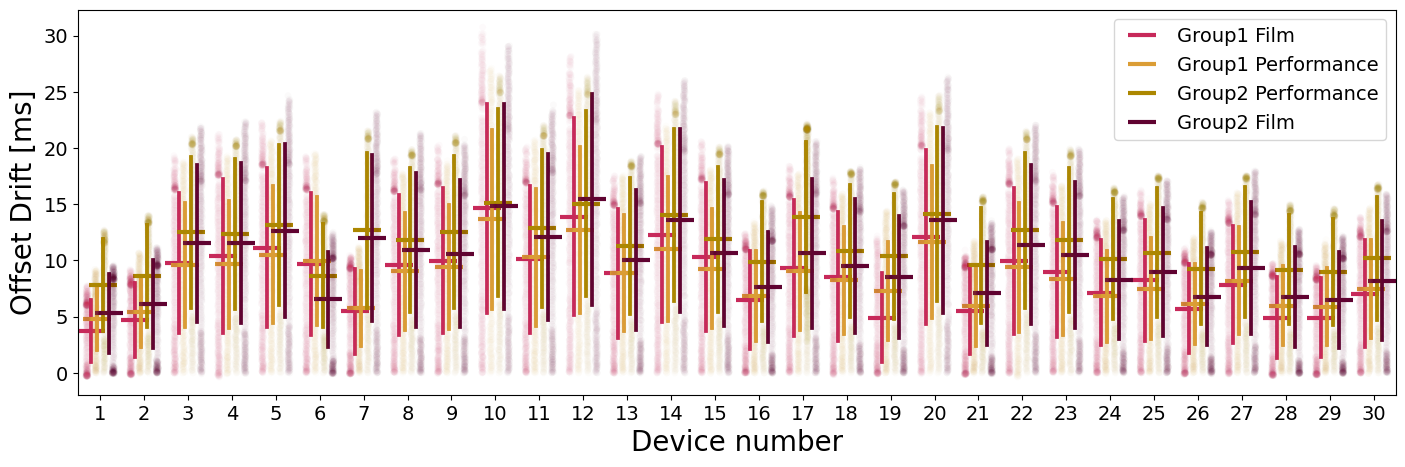

In [838]:
plt.figure(figsize=(17,5))

sns.stripplot(
    data=concat_df, x="device", y="drift", hue="condition",
    palette = groups_palette,
    dodge=True, alpha=.02, legend=False,
)
sns.pointplot(
    data=concat_df, x="device", y="drift", hue="condition",
    dodge=.4, linestyle="none", errorbar="sd", palette = groups_palette,
    marker="_", markersize=20, markeredgewidth=3#, capsize=0.1
)
ax= plt.gca()
ax.set_xticklabels([int(ip_.split(".")[-1])-150 for ip_ in concat_df.device.unique()], fontsize=14)
ax.tick_params(axis='y', labelsize=14) 
ax.set_ylabel("Offset Drift [ms]", fontsize=20)
ax.set_xlabel("Device number", fontsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Group1 Film', 'Group1 Performance', 'Group2 Performance', 'Group2 Film'], 
          title="", fontsize=14, title_fontsize=0)
# plt.savefig("plt_dumps/offset_drift_combined.png", dpi = 300, bbox_inches="tight")

In [55]:
concat_df.groupby("condition").describe()

drift                                                     \
                    count       mean       std   min     25%    50%      75%   
condition                                                                      
day1_film         11258.0   8.577716  6.479156 -0.38  2.6625   8.12  13.4200   
day1_performance   9330.0   8.485118  5.543862 -0.36  3.9200   8.06  12.3075   
day2_film         12270.0   9.915781  6.882049 -0.09  3.3725  10.08  15.0500   
day2_performance   9282.0  11.521342  6.530656  0.00  5.7000  12.09  16.5100   

                         
                    max  
condition                
day1_film         30.74  
day1_performance  27.09  
day2_film         30.12  
day2_performance  26.41

RANSAC Fits for each recording

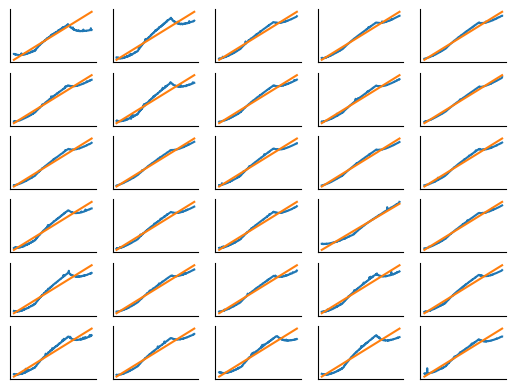

In [75]:
from sklearn import linear_model

fig, axs = plt.subplots(6,5)
device_scores = {}
for i in range(1, 31):
    device = f"192.168.35.{150+i}"
    device_offsets_df = offsets_film_day1[offsets_film_day1.device == device]
    X = device_offsets_df["timestamp [ns]"].to_numpy().reshape(-1,1) 
    y = device_offsets_df["mean time offset [ms]"].to_numpy().reshape(-1, 1)
    ransac = linear_model.RANSACRegressor().fit(X, y)
    device_scores[device] = ransac.score(X, y)
    ax = axs[(i-1)//5][(i-1)%5] 
    ax.plot(device_offsets_df["timestamp [ns]"], device_offsets_df["mean time offset [ms]"])
    ax.plot([X.min(), X.max()], [ransac.predict(np.array(X.min()).reshape(1,-1))[0,0], ransac.predict(np.array(X.max()).reshape(1,-1))[0,0]])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

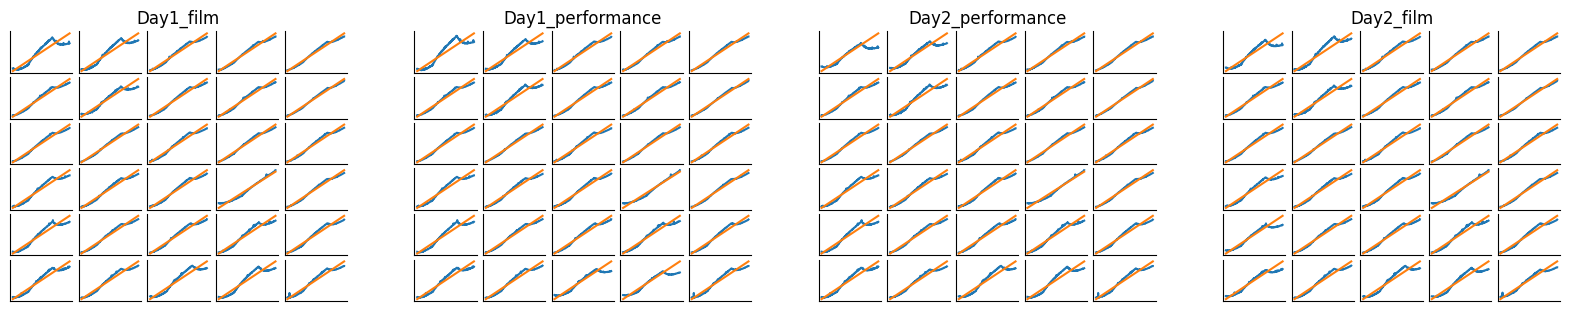

In [104]:
scores = {}
fig = plt.figure(figsize=(20, 3.5))
outer = gridspec.GridSpec(1, 4, wspace=0.2, hspace=0.2)

for i, condition in enumerate(["Day1_film", "Day1_performance", "Day2_performance", "Day2_film"]):
    inner = gridspec.GridSpecFromSubplotSpec(6, 5, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    device_scores = {}
    axs = fig.add_subplot(outer[i])
    axs.set_title(condition)
    axs.set_axis_off()
    
    for j in range(1, 31):
        device = f"192.168.35.{150+j}"
        device_offsets_df = offsets_film_day1[offsets_film_day1.device == device]
        X = device_offsets_df["timestamp [ns]"].to_numpy().reshape(-1,1) 
        y = device_offsets_df["mean time offset [ms]"].to_numpy().reshape(-1, 1)
        ransac = linear_model.RANSACRegressor().fit(X, y)
        device_scores[device] = ransac.score(X, y)
        # ax_i = axs[(i-1)//5][(i-1)%5] 
        ax = plt.Subplot(fig, inner[j-1])
        ax.plot(device_offsets_df["timestamp [ns]"], device_offsets_df["mean time offset [ms]"])
        ax.plot([X.min(), X.max()], [ransac.predict(np.array(X.min()).reshape(1,-1))[0,0], ransac.predict(np.array(X.max()).reshape(1,-1))[0,0]])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        fig.add_subplot(ax)
    scores[condition] = device_scores
# plt.savefig("plt_dumps/offsets_comb.png")

In [108]:
pd.DataFrame.from_dict(scores).describe()

Day1_film  Day1_performance  Day2_performance  Day2_film
count  30.000000         30.000000         30.000000  30.000000
mean    0.954605          0.950394          0.947652   0.951370
std     0.033229          0.043501          0.061536   0.039311
min     0.842625          0.804575          0.659385   0.815059
25%     0.943406          0.943259          0.943406   0.942048
50%     0.968135          0.968135          0.968135   0.968135
75%     0.975377          0.975377          0.975377   0.975377
max     0.989026          0.989026          0.989026   0.989026

## Gaze

In [19]:
import utils
from importlib import reload
reload(utils)
from utils import *

In [20]:
#calculating diagonal size (in pixels) of the videowall projected to the three rows' worldview
#projected visual angle of the videowall on the three rows is calculated using the physical dimensions of the videoWall (384.5x216cm) and the distance of each row from it.
diag_row1 = math.sqrt((256 - 495)**2 + (204-108)**2) * 2 #size calculated in half resolution
sigma_row1 = int(diag_row1/32.4) #32.4 vis deg angle projected by videowall diagonal
diag_row2 = math.sqrt((282 - 478)**2 + (279-178)**2) * 2
sigma_row2 = diag_row2/28
diag_row3 = math.sqrt((498 - 327)**2 + (181-81)**2) * 2
sigma_row3 = diag_row3/24.6

## all three sigmas can be approximated to 16 pixels for 1 visual degree
SIGMA = 16

## averaging the visual degree projected by videoWall for the three rows. Using this to calculate sigma for homography transformed gaze space
SIGMAH = int(math.sqrt((246-489)**2 + (146-307)**2)/np.array([24.6, 28,32.4]).mean())

In [1194]:
%store SIGMAH

Stored 'SIGMAH' (int)


In [21]:
# seat_numbers = np.arange(1,31).reshape(3,10)
# seat numbers for both days

seat_numbers = {
    1: np.array([[ 1,  2,  3,  5,  10,  6,  7,  8,  9, 4],
       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
       [21, 22, 24, 23, 25, 26, 27, 28, 29, 30]]),
    2: np.array([[ 1,  2,  3,  4,  5,  10,  7,  8,  9, 6],
       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]])}

### Egocentric Gaze

This is the raw gaze output (x,y) in worldview coordinates recorded by the eye-tracking glasses from the wearer's perspective. \
The raw gaze is however recorded at 200 Hz and the worldview is recorded at 30 Hz. \
The worldview resolution limits the transformed gaze resolution to be 30 Hz and therefore we'll downsample raw gaze to 30Hz for a fair comparison with transformed gaze.

In [ ]:
#For each device path, merge gaze and world samples using corrected timestamps (using offlineInterface in SocialEyes) and save the merged df
device_paths = glob.glob(os.path.join(DATA_PATH, f"EventDay?/Eyes/CompanionDevices/*.*.*.*/Neon/b5b4*/*/export_PLCloud/*/"))
for path in tqdm(device_paths):
    gaze_csv = pd.read_csv(os.path.join(path, "ts_corr_gaze.csv"))
    world_csv = pd.read_csv(os.path.join(path, "ts_corr_world_timestamps.csv"))

    gaze_and_world_df = pd.merge_asof(
        world_csv.sort_values("timestamp_corrected") ,
        gaze_csv.sort_values("timestamp_corrected") ,
        on="timestamp_corrected",
        direction="nearest",
        suffixes=["_world", "_gaze"])

    gaze_and_world_df.to_csv(os.path.join(path, "timesynced_gaze_and_world.csv"))

In [ ]:
gaze_fname =  "timesynced_gaze_and_world.csv"#"ts_corr_gaze.csv" to use the 200Hz raw gaze
gaze_dfs = glob.glob(os.path.join(DATA_PATH, f"EventDay?/Eyes/CompanionDevices/*.*.*.*/Neon/b5b4*/*/export_PLCloud/*/{gaze_fname}"))
ego_gaze = pd.DataFrame(columns = ["Device", "Day", "Medium", "Entropy", "Velocity", "Heatmap"])

for path in tqdm(gaze_dfs):
    df = pd.read_csv(path)
    #Reject blink samples and gaze outside worldview frames
    df = df[df["blink id"].isnull()]
    df = reject_pts_outside_frame(df, x_lim=(0,1600), y_lim=(0,1200), x_col= "gaze x [px]", y_col ="gaze y [px]")
    df.dropna(subset = ["gaze x [px]", "gaze y [px]"], inplace=True)
    ## calculate mean gaze velocity 
    velocity, _ = gaze_velocity(df, "gaze x [px]", "gaze y [px]")        
    ## calculate stationary entropy
    entropy = stationary_entropy(df, "gaze x [px]", "gaze y [px]", bin_size=SIGMA, screen_dim=(1600,1200))
    ## calculate heatmap
    heatmap = generate_heatmap(df["gaze x [px]"].astype(int), df["gaze y [px]"].astype(int), res = (1600,1200), sigma = SIGMA)
    ## get device name
    try:
        ip = re.findall(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', path)[0]
        device_name = "G" + str(int(ip.split(".")[-1])-150).zfill(3)
        day, medium = re.findall(r'day(.)_(.*?)/', path)[0]
    except Exception as e:
        print("Re match failed", e)
        break
        
    ## save to dataframe
    ego_gaze.loc[len(ego_gaze)] = {"Device": device_name, "Day": day, "Medium": medium, "Entropy":entropy, "Velocity": velocity, "Heatmap": heatmap}

In [24]:
#Remove Device G026 since participant left study after first half
ego_gaze = ego_gaze[~((ego_gaze.Device == "G026") & (ego_gaze.Day == "1") & (ego_gaze.Medium == "performance"))]
ego_gaze.groupby(["Day", "Medium"]).count()

Device  Entropy  Velocity  Heatmap
Day Medium                                         
1   film             30       30        30       30
    performance      29       29        29       29
2   film             30       30        30       30
    performance      30       30        30       30

In [25]:
ego_gaze.head()

Device Day       Medium   Entropy   Velocity  \
0   G001   1  performance  0.727766  12.205624   
1   G001   1         film  0.703097  13.029355   
2   G002   1         film  0.763301  21.144520   
3   G002   1  performance  0.717985  14.133465   
4   G003   1  performance  0.723214  10.773620   

                                             Heatmap  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

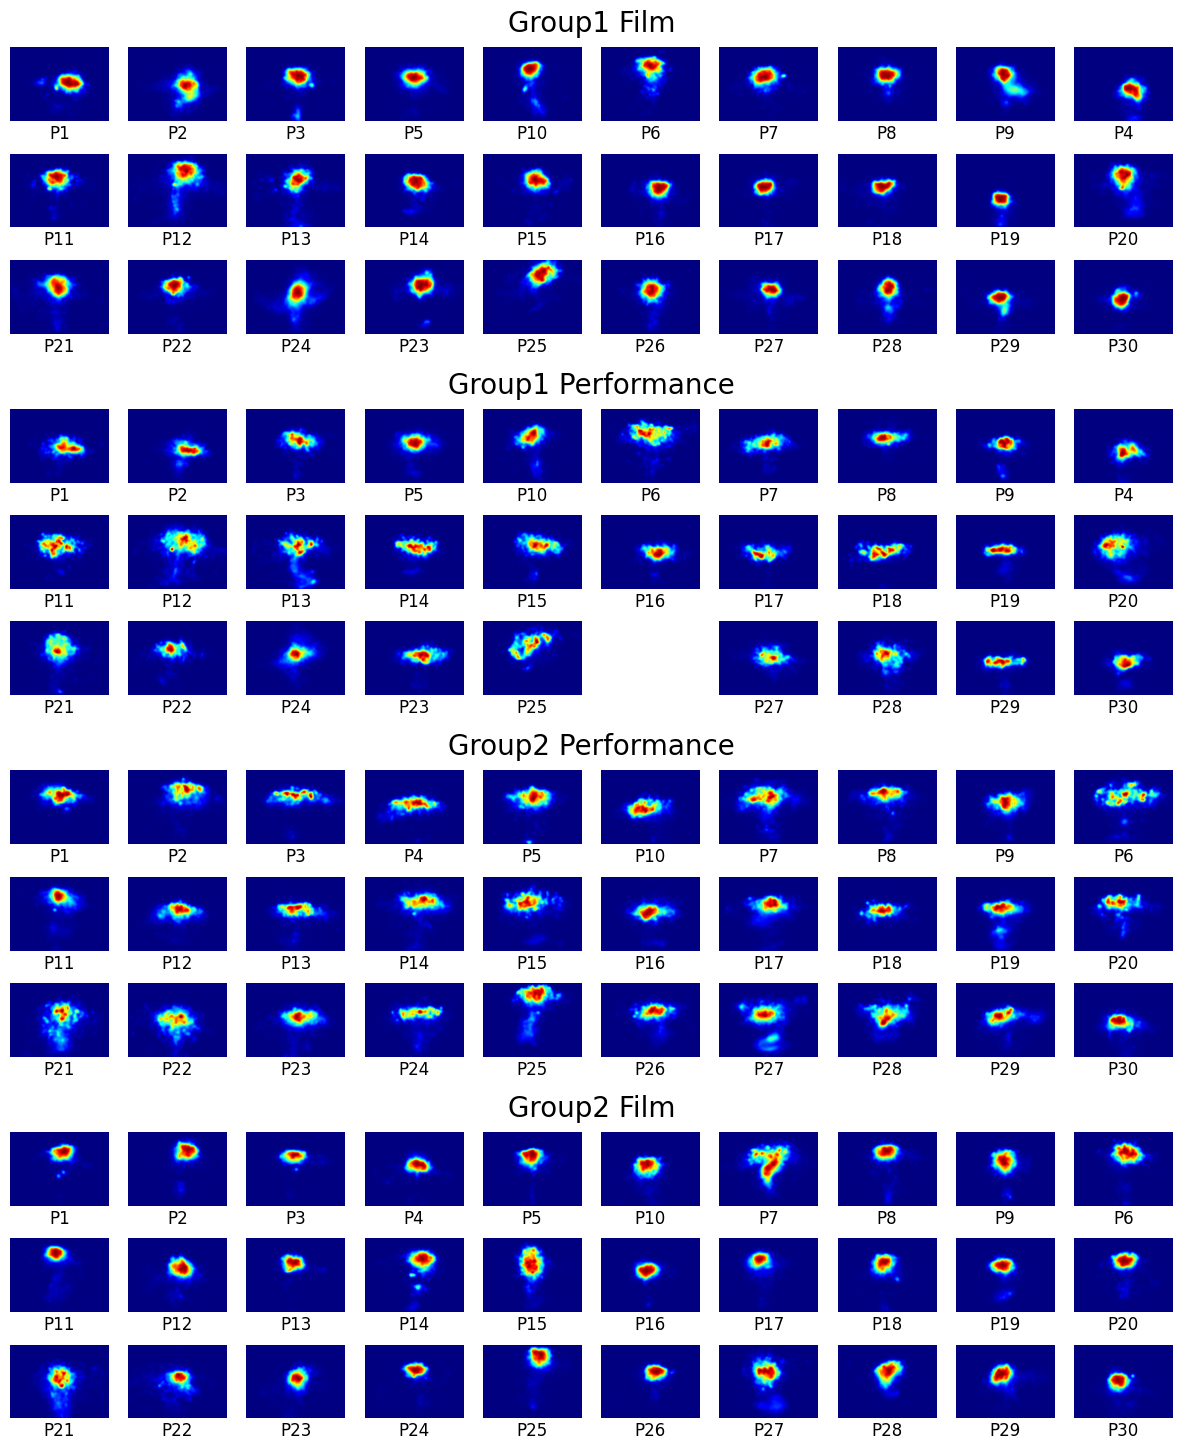

In [1187]:
fig = plt.figure(figsize=(15, 18))
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

for i, (vals, df) in enumerate(ego_gaze.groupby(["Day", "Medium"])):
    if i in (2, 3):
        i = 5 - i #reverse order for day 2
    inner = gridspec.GridSpecFromSubplotSpec(3,10,
                    subplot_spec=outer[i])
    
    ax = fig.add_subplot(outer[i])
    ax.set_title(f"Group{vals[0]} {str(vals[1]).capitalize()}", fontsize=20)
    ax.set_axis_off()  # Hide the main subplot's axis
    
    for idx, row in df.iterrows():
        device_n = int(row["Device"][-2:])
        i, j = np.where(seat_numbers[int(vals[0])]==device_n)
        ax = fig.add_subplot(inner[int(i), int(j)])
        ax.imshow(plot_heatmap(row["Heatmap"])[:,:,::-1])
        ax.set_title(f"P{int(row['Device'][-2:])}", fontsize=12, loc='center', y=-0.35)
        ax.axis("off")
        fig.add_subplot(ax)
    plt.tight_layout()
plt.tight_layout()
# plt.savefig("plt_dumps/heatmaps_egocentric.png", dpi=300, bbox_inches="tight")

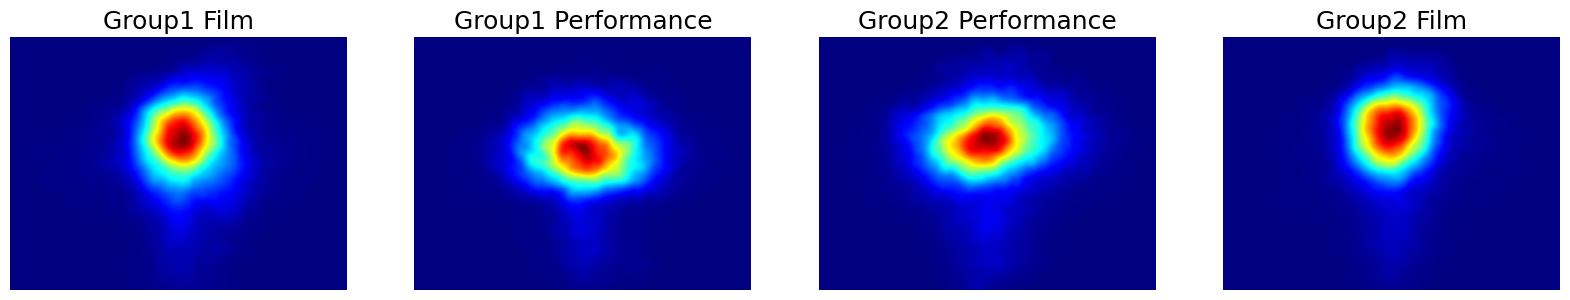

In [1035]:
#Averaged heatmaps
fig, axs = plt.subplots(1,4, figsize=(20,4))
for i, (vals, df) in enumerate(ego_gaze.groupby(["Day", "Medium"])):
    if i==2:
        i=3
    elif i==3:
        i=2
    heatmap_avg = df["Heatmap"].mean(axis=0)
    axs[i].imshow(plot_heatmap(heatmap_avg)[:,:,::-1])
    axs[i].set_title(f"Group{vals[0]} {str(vals[1]).capitalize()}", fontsize=18)
    axs[i].set_axis_off()
# plt.savefig("plt_dumps/heatmaps_egocentric_avg.png", dpi=300, bbox_inches="tight")

Entropy and Velocity

In [796]:
ego_gaze[["Day", "Medium", "Entropy", "Velocity"]].groupby(["Day", "Medium"]).mean()

Entropy   Velocity
Day Medium                          
1   film         0.667634  52.397421
    performance  0.695340  60.179068
2   film         0.672546  47.835860
    performance  0.727268  65.802486

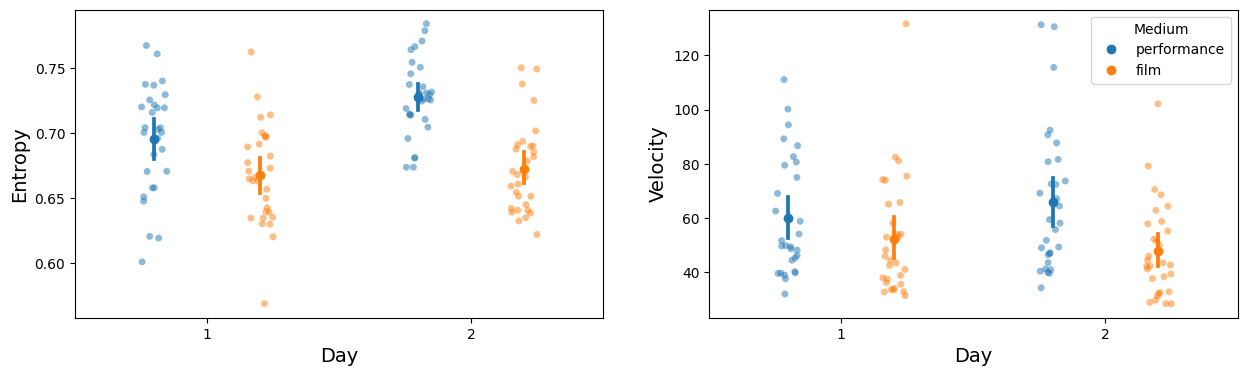

In [798]:
fig, axs = plt.subplots(1,2, figsize = (15,4))

for i, measure in enumerate(["Entropy", "Velocity"]):
    if i==0:
        show_legend = False
    else:
        show_legend = True
    sns.stripplot(
        data=ego_gaze, x = "Day", hue="Medium", y=measure,
        dodge=True, alpha=.5 , legend=False, ax = axs[i] , hue_order = ['performance', 'film'])
                                        # 'mean roundtrip duration [ms]day2_perf', 'mean roundtrip duration [ms]day2_film'], ax=axs[1])
    sns.pointplot(
        data=ego_gaze, x = "Day", hue="Medium", y=measure,
        linestyle="none", errorbar="ci", dodge=.4, hue_order = ['performance', 'film'],
        marker=".", markersize=10, markeredgewidth=2, alpha = 1, ax = axs[i], legend = show_legend) 
    axs[i].set_ylabel(measure, fontsize=14)
    axs[i].set_xlabel("Day", fontsize=14)

# plt.savefig("plt_dumps/gaze_measures_egocentric.png", dpi=300, bbox_inches='tight')
plt.show()

### Transformed Gaze

This is the homography transformed gaze output (x,y) in centerview coordinates projected by the Homography module of SocialEyes.
Being on a common coordinate system, gaze points across participants can now be aggregated and compared directly!


In [135]:
from st_dbscan import ST_DBSCAN 
def DB_centroids(data, eps_spatial, eps_temporal=6, min_samples=2):
    st_dbscan = ST_DBSCAN(eps1 = eps_spatial, eps2 = eps_temporal, min_samples = min_samples).fit(data) #eps2 = 6 set from webcam ET paper (Saxena et. al., 2023) since data is 30 Hz
    centroids = np.empty((0,2), int)
    #Exclude outliers and first fixation
    for cl in range(1, max(st_dbscan.labels)):
        centroids = np.append(centroids, np.median(data[st_dbscan.labels==cl,:], axis = 0)[1:].reshape(-1,2), axis=0)
    return centroids.astype(int)

##### Blink removal

In [228]:
homography_paths = glob.glob(os.path.join(DATA_PATH, f"EventDay?/HomographyResults*/transformed_gaze_G???.csv"))
pattern = r'/EventDay(\d+)/HomographyResults_(\w+)/transformed_gaze_(\w+)\.csv'

for path in tqdm(homography_paths):
    #read homography transformed gaze df
    hom_df = pd.read_csv(path)

    #find corresponding blinks df
    match = re.search(pattern, path)
    if match:
        day = match.group(1)
        session = match.group(2)
        device = match.group(3)
        device_ip = f"192.168.35.{150+int(device[-3:])}"
    else:
        print("cound not find re pattern in", path)
        continue
    blinks_path = glob.glob(os.path.join(DATA_PATH, f"EventDay{day}/Eyes/CompanionDevices/{device_ip}/*/*/*day{day}_{session}/export_PLCloud/*/ts_corr_blinks.csv"))[0]
    blinks_df = pd.read_csv(blinks_path)

    #initiate and populate blinks column
    blink_ids = pd.Series([np.nan]*hom_df.shape[0])
    for i,row in blinks_df.iterrows():
        blink_ids[(row["start timestamp_corrected"] <= hom_df["timestamp [ns]"]) & (hom_df["timestamp [ns]"] <= row["end timestamp_corrected"])] = row["blink id"]

    #save to hom_df
    hom_df["blink id"] = blink_ids
    hom_df.to_csv(path, index=False)

  0%|          | 0/119 [00:00<?, ?it/s]

Aggregate gaze of all participants and calculate measures from analysis module

In [851]:
df = pd.read_csv(homography_paths[0])

In [908]:
homography_paths = glob.glob(os.path.join(DATA_PATH, f"EventDay?/HomographyResults*/transformed_gaze_G???.csv"))
hom_gaze = pd.DataFrame(columns = ["Device", "Day", "Medium", "Entropy", "Velocity", "Heatmap"])

for path in tqdm(homography_paths):
    df = pd.read_csv(path)
    #Reject blinks and points outside frame
    df = df[df["blink id"].isnull()]
    df = reject_pts_outside_frame(df, x_lim=(0,640), y_lim=(0,480), x_col= "transformed_gaze_x", y_col ="transformed_gaze_y")
    df.dropna(subset = ["transformed_gaze_x", "transformed_gaze_y"], inplace=True)
    ## calculate mean gaze velocity 
    velocity, _ = gaze_velocity(df, "transformed_gaze_x", "transformed_gaze_y")        
    ## calculate stationary entropy
    entropy = stationary_entropy(df, "transformed_gaze_x", "transformed_gaze_y", bin_size=SIGMAH, screen_dim=(640,480))
    ## calculate heatmap
    heatmap = generate_heatmap(df["transformed_gaze_x"].astype(int), df["transformed_gaze_y"].astype(int), res = (640,480), sigma = SIGMAH)
    ## get device name
    try:
        device_name = os.path.basename(path).split("_")[-1][:-4]
        day = re.findall(r'EventDay(\d+)', path)[0]
        medium = re.findall(r'HomographyResults_(\w+)', path)[0]
    except Exception as e:
        print("Re match failed", e)
        break
        
    ## save to dataframe
    hom_gaze.loc[len(hom_gaze)] = {"Device": device_name, "Day": day, "Medium": medium, "Entropy":entropy, "Velocity": velocity, "Heatmap": heatmap}

  0%|          | 0/120 [00:00<?, ?it/s]

In [909]:
#Remove Device G026 since participant left study after first half
hom_gaze = hom_gaze[~((hom_gaze.Device == "G026") & (hom_gaze.Day == "1") & (hom_gaze.Medium == "performance"))]
hom_gaze.groupby(["Day", "Medium"]).count()

Device  Entropy  Velocity  Heatmap
Day Medium                                         
1   film             30       30        30       30
    performance      29       29        29       29
2   film             30       30        30       30
    performance      30       30        30       30

#### Individual heatmaps

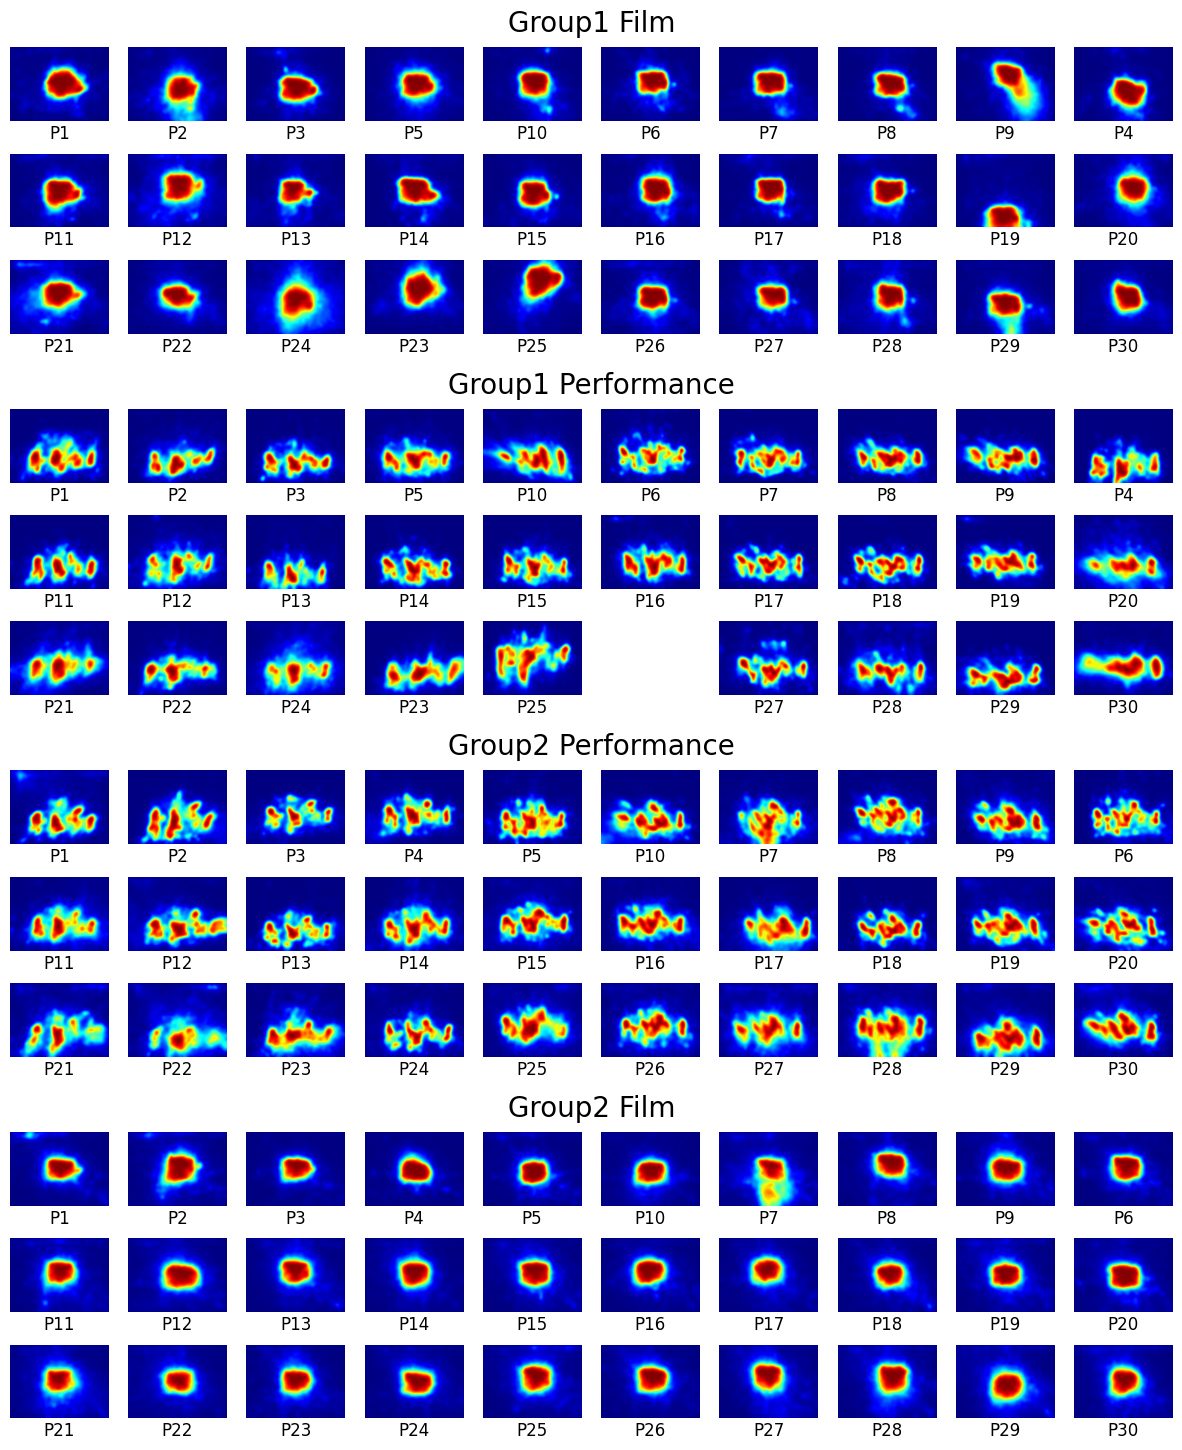

In [1042]:
fig = plt.figure(figsize=(15, 18))
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

for i, (vals, df) in enumerate(hom_gaze.groupby(["Day", "Medium"])): 
    if i in (2, 3):
        i = 5 - i #reverse order for day 2
    inner = gridspec.GridSpecFromSubplotSpec(3,10,
                    subplot_spec=outer[i])
    
    ax = fig.add_subplot(outer[i])
    ax.set_title(f"Group{vals[0]} {str(vals[1]).capitalize()}", fontsize=20)
    ax.set_axis_off()  # Hide the main subplot's axis
    
    for idx, row in df.iterrows():
        device_n = int(row["Device"][-2:])
        i, j = np.where(seat_numbers[int(vals[0])]==device_n)
        ax = fig.add_subplot(inner[int(i), int(j)])
        ax.imshow(plot_heatmap(row["Heatmap"])[:,:,::-1])
        ax.set_title(f"P{int(row['Device'][-2:])}", fontsize=12, loc='center', y=-0.35)
        ax.axis("off")
        fig.add_subplot(ax)
    plt.tight_layout()
plt.tight_layout()
plt.savefig("plt_dumps/heatmaps_homography.png", dpi=300, bbox_inches="tight")

#### Averaged Heatmaps

Row-wise

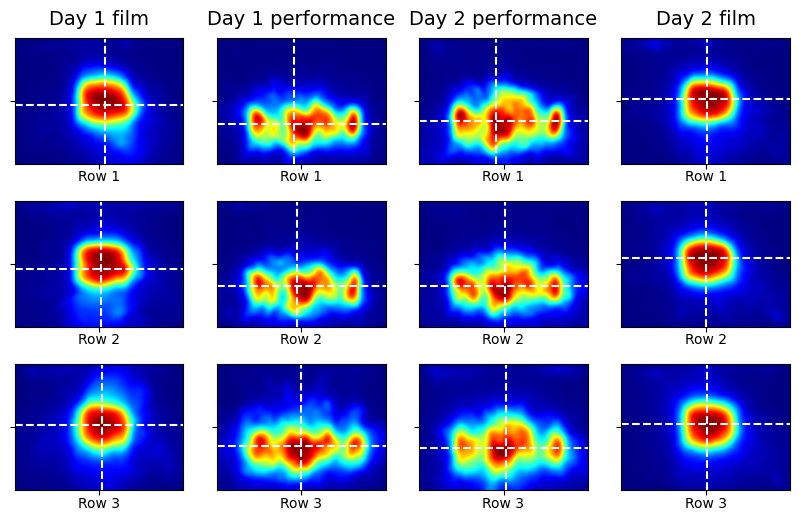

In [912]:
fig = plt.figure(figsize=(10, 6))
outer = gridspec.GridSpec(1, 4, wspace=0.2, hspace=0.2)

for i, (vals, df) in enumerate(hom_gaze.groupby(["Day", "Medium"])):    
    if i in (2, 3):
        i = 5 - i #reverse order for day 2
    inner = gridspec.GridSpecFromSubplotSpec(3,1,
                    subplot_spec=outer[i])
    
    ax = fig.add_subplot(outer[i])
    ax.set_title(f"Day {vals[0]} {vals[1]}", fontsize=14)
    ax.set_axis_off()  # Hide the main subplot's axis

    for rn in range(3): #for each row
        dn = seat_numbers[int(vals[0])][rn] #select device numbers from the row
        sub_df = df.loc[df["Device"].isin(["G{:03d}".format(n) for n in dn])]
        heatmap_avg = sub_df["Heatmap"].mean(axis=0)
        #plot the heatmap average
        ax = fig.add_subplot(inner[rn])
        ax.imshow(plot_heatmap(heatmap_avg)[:,:,::-1], alpha = 1)
        #plot centroid (means in x and y)
        x_mean = np.argmax(heatmap_avg.mean(axis=0))
        y_mean = np.argmax(heatmap_avg.mean(axis=1))
        ax.axvline(x = x_mean, linestyle="--", color="white")
        ax.axhline(y = y_mean, linestyle="--", color="white")
        
        ax.set_title(f"Row {rn+1}", fontsize=10,loc='center', y=-0.2)
        # ax.set_axis_off()
        ax.set_xticks([640/2], [""])
        ax.set_yticks([480/2], [""])
        # ax.set_tickparams(width=2)

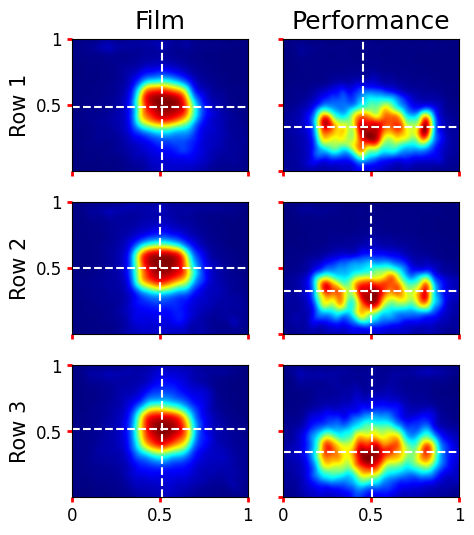

In [1025]:
fig = plt.figure(figsize=(5, 6))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

for i, (vals, df) in enumerate(hom_gaze.groupby("Medium")):
    inner = gridspec.GridSpecFromSubplotSpec(3,1,
                    subplot_spec=outer[i])
    
    ax = fig.add_subplot(outer[i])
    ax.set_title(vals.capitalize(), fontsize=18)
    ax.set_axis_off()  # Hide the main subplot's axis
    
    for rn in range(3): #for each row
        heatmaps = pd.Series()
        for day in range(1,3):
            dn = seat_numbers[day][rn,:] #select device numbers from the row
            sub_df = df.loc[(df["Day"]==str(day)) & (df["Device"].isin(["G{:03d}".format(n) for n in dn]))]
            heatmaps = pd.concat([heatmaps, sub_df["Heatmap"]])
        heatmap_avg = heatmaps.mean(axis=0)
        #plot the heatmap average
        ax = fig.add_subplot(inner[rn])
        ax.imshow(plot_heatmap(heatmap_avg)[:,:,::-1], alpha = 1)
        #plot centroid (means in x and y)
        x_mean = np.argmax(heatmap_avg.mean(axis=0))
        y_mean = np.argmax(heatmap_avg.mean(axis=1))
        ax.axvline(x = x_mean, linestyle="--", color="white")
        ax.axhline(y = y_mean, linestyle="--", color="white")

        #fig texts
        if i==0:
            ax.set_ylabel(f"Row {rn+1}", fontsize=15)
            ax.set_yticks([0, 480/2], [1, 0.5],fontsize=12)
        else:
            ax.set_yticks([0, 480/2, 480], ["", "", ""], fontsize=12)
        if rn == 2:        
            ax.set_xticks([0, 640/2, 640], [0, 0.5, 1], fontsize=12)
        else:
            ax.set_xticks([0, 640/2, 640], ["", "", ""], fontsize=12)
        
        ax.tick_params(width=2, color="red")
        
        # ax.set_title(f"Row {rn+1}", fontsize=10,loc='center', y=-0.2)
        # # ax.set_axis_off()
        # ax.set_xticks([640/2], [""])
        # ax.set_yticks([480/2], [""])
        # ax.set_tickparams(width=2)
# plt.savefig("plt_dumps/avg_heatmaps_rows.png", dpi=300, bbox_inches="tight")

Column wise

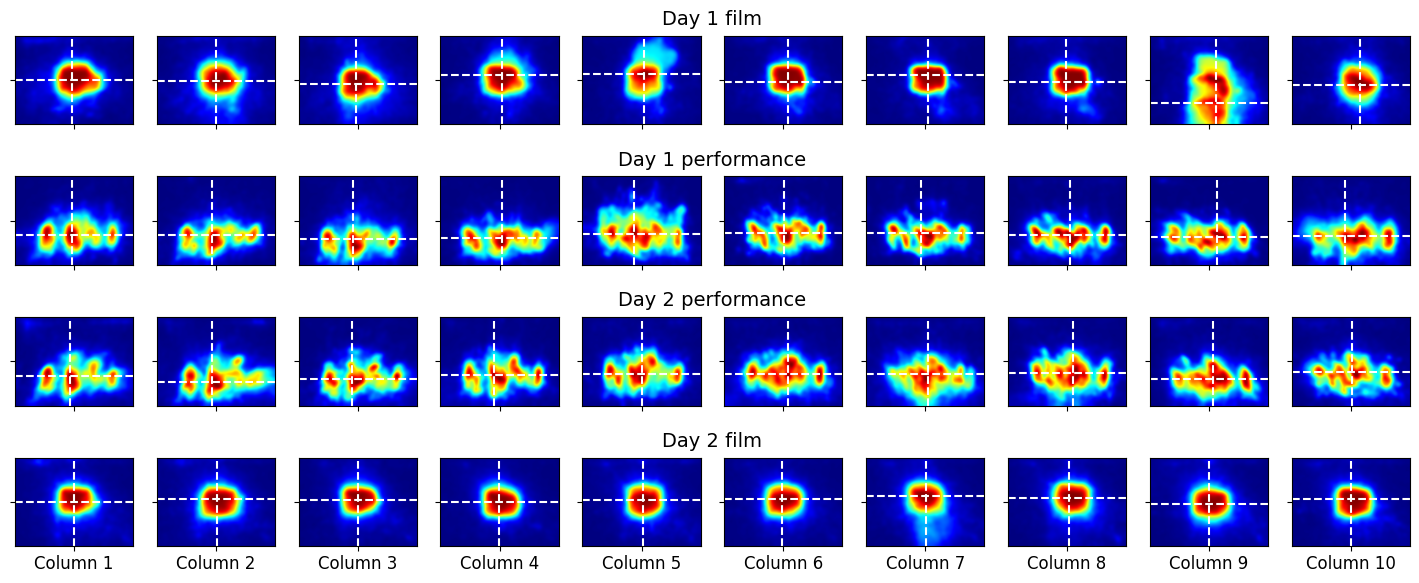

In [913]:
fig = plt.figure(figsize=(18, 7))
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

for i, (vals, df) in enumerate(hom_gaze.groupby(["Day", "Medium"])):  
    if i in (2, 3):
        i = 5 - i #reverse order for day 2
    inner = gridspec.GridSpecFromSubplotSpec(1,10,
                    subplot_spec=outer[i])
    
    ax = fig.add_subplot(outer[i])
    ax.set_title(f"Day {vals[0]} {vals[1]}", fontsize=14, y=0.9)
    ax.set_axis_off()  # Hide the main subplot's axis

    for cn in range(10): #for each column
        dn = seat_numbers[int(vals[0])][:,cn] #select device numbers from the column
        sub_df = df.loc[df["Device"].isin(["G{:03d}".format(n) for n in dn])]
        heatmap_avg = sub_df["Heatmap"].mean(axis=0)
        #plot the heatmap average
        ax = fig.add_subplot(inner[cn])
        ax.imshow(plot_heatmap(heatmap_avg)[:,:,::-1], alpha = 1)
        #plot centroid (means in x and y)
        x_mean = np.argmax(heatmap_avg.mean(axis=0))
        y_mean = np.argmax(heatmap_avg.mean(axis=1))
        ax.axvline(x = x_mean, linestyle="--", color="white")
        ax.axhline(y = y_mean, linestyle="--", color="white")
        
        if i==3:
            ax.set_title(f"Column {cn+1}", fontsize=12,loc='center', y=-0.35)
        ax.set_xticks([640/2], [""])
        ax.set_yticks([480/2], [""])
        # ax.set_axis_off()
        

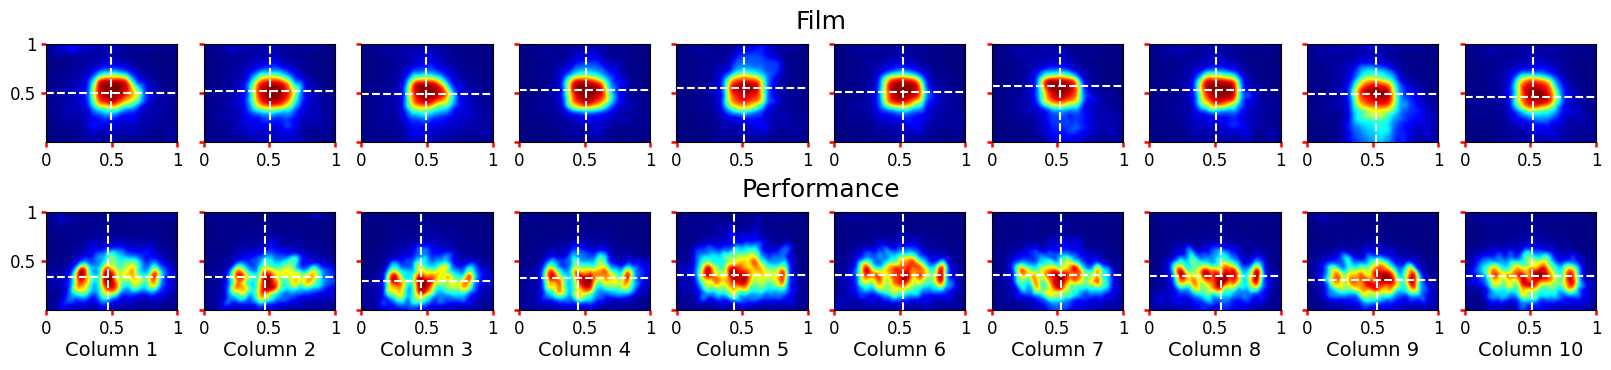

In [1018]:
fig = plt.figure(figsize=(20, 4))
outer = gridspec.GridSpec(2, 1, wspace=0.5, hspace=0.2)

for i, (vals, df) in enumerate(hom_gaze.groupby("Medium")):  
    inner = gridspec.GridSpecFromSubplotSpec(1,10,
                    subplot_spec=outer[i])
    
    ax = fig.add_subplot(outer[i])
    ax.set_title(vals.capitalize(), fontsize=18, y=0.9)
    ax.set_axis_off()  # Hide the main subplot's axis

    for cn in range(10):
        heatmaps = pd.Series()
        for day in range(1,3): #for each column
            dn = seat_numbers[day][:,cn] #select device numbers from the column
            sub_df = df.loc[(df["Day"]==str(day)) & (df["Device"].isin(["G{:03d}".format(n) for n in dn]))]
            heatmaps = pd.concat([heatmaps, sub_df["Heatmap"]])
        heatmap_avg = heatmaps.mean(axis=0)
        #plot the heatmap average
        ax = fig.add_subplot(inner[cn])
        ax.imshow(plot_heatmap(heatmap_avg)[:,:,::-1], alpha = 1)
        #plot centroid (means in x and y)
        x_mean = np.argmax(heatmap_avg.mean(axis=0))
        y_mean = np.argmax(heatmap_avg.mean(axis=1))
        ax.axvline(x = x_mean, linestyle="--", color="white")
        ax.axhline(y = y_mean, linestyle="--", color="white")
        
        if i==1:
            ax.set_title(f"Column {cn+1}", fontsize=14,loc='center', y=-0.55)
        # ax.axvline(x = [640/2], linestyle="-", color="white")
        # ax.axhline(y = [480/2], linestyle="-", color="white")
        ax.set_xticks([0, 640/2, 640], [0, 0.5, 1], fontsize=12)
        if cn==0:
            ax.set_yticks([0, 480/2], [1, 0.5], fontsize=12)
        else:
            ax.set_yticks([0, 480/2, 480], ["", "", ""], fontsize=12)
        ax.tick_params(width=1.8, color="red")
        # ax.set_axis_off()
# plt.savefig("plt_dumps/avg_heatmaps_columns.png", dpi=300, bbox_inches="tight")

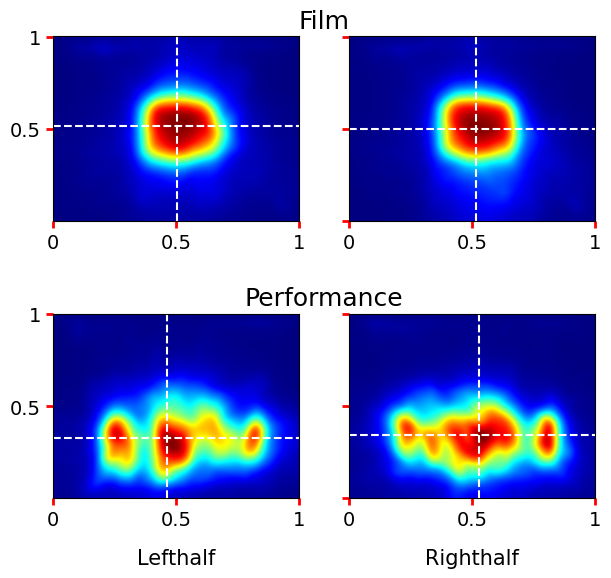

In [1008]:
fig = plt.figure(figsize=(7, 6))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)
heatmaps = {}

for i, (vals, df) in enumerate(hom_gaze.groupby("Medium")):  
    inner = gridspec.GridSpecFromSubplotSpec(1,2,
                    subplot_spec=outer[i])
    
    ax = fig.add_subplot(outer[i])
    ax.set_title(vals.capitalize(), fontsize=18)
    ax.set_axis_off()  # Hide the main subplot's axis

    for hn in range(2): #for each column
        heatmaps = pd.Series()
        for day in range(1,3):
            dn = seat_numbers[day][:,hn*5:(hn*5)+5].flatten() #select device numbers from the left of right half
            sub_df = df.loc[(df["Day"]==str(day)) & (df["Device"].isin(["G{:03d}".format(n) for n in dn]))]
            heatmaps = pd.concat([heatmaps, sub_df["Heatmap"]])
        heatmap_avg = heatmaps.mean(axis=0)
        #plot the heatmap average
        ax = fig.add_subplot(inner[hn])
        ax.imshow(plot_heatmap(heatmap_avg)[:,:,::-1], alpha = 1)
        #plot centroid (means in x and y)
        x_mean = np.argmax(heatmap_avg.mean(axis=0))
        y_mean = np.argmax(heatmap_avg.mean(axis=1))
        ax.axvline(x = x_mean, linestyle="--", color="white")
        ax.axhline(y = y_mean, linestyle="--", color="white")
        
        
        #fig texts
        if i==1:
            ax.set_title( f"{'Left' if hn==0 else 'Right'}half", fontsize=15,loc='center', y=-0.4)

        ax.set_xticks([0, 640/2, 640], [0, 0.5, 1], fontsize=14)
        if hn==0:
            ax.set_yticks([0, 480/2], [1, 0.5], fontsize=14)
        else:
            ax.set_yticks([0, 480/2, 480], ["", "", ""], fontsize=14)
        ax.tick_params(width=2, length=5, color="red")
        # Calculate deviation from center?
        # deviation = np.sqrt((average_x - center_x)**2 + (average_y - center_y)**2)
# plt.savefig("plt_dumps/avg_heatmaps_halves.png", dpi=300, bbox_inches="tight")

averaging over both days for each half row-wise

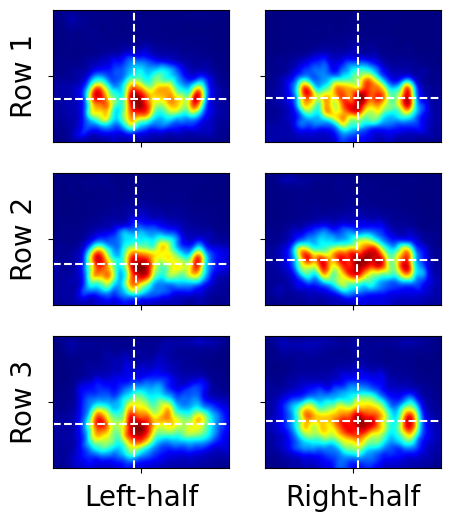

In [943]:
fig,axs = plt.subplots(3,2, figsize=(5,6))
performance_df = hom_gaze[hom_gaze["Medium"] == "performance"]

for hn in range(2): #0=left half and 1=right half
    for row in range(3):
        ax = axs[row][hn]
        heatmaps = pd.Series()
        for day in range(1,3):
            dn = seat_numbers[int(day)][row,hn*5:(hn*5)+5].flatten()
            #get all heatmaps from resp. half
            sub_df = hom_gaze[(hom_gaze["Day"] == str(day)) & (hom_gaze["Medium"] == "performance")]
            heatmaps = pd.concat([heatmaps, sub_df.loc[sub_df["Device"].isin(["G{:03d}".format(n) for n in dn])]["Heatmap"]])
        heatmap_avg = heatmaps.mean(axis=0)
        ax.imshow(plot_heatmap(heatmap_avg)[:,:,::-1], alpha = 1)

        #plot centroid lines
        x_mean = np.argmax(heatmap_avg.mean(axis=0))
        y_mean = np.argmax(heatmap_avg.mean(axis=1))
        ax.axvline(x = x_mean, linestyle="--", color="white")
        ax.axhline(y = y_mean, linestyle="--", color="white")
        
        
        #figure texts
        if row == 2:
            ax.set_title(f"{'Left' if hn==0 else 'Right'}-half", fontsize=20,loc='center', y=-0.35)
        if hn == 0:
            ax.set_ylabel(f"Row {row+1}", fontsize=20)
        
        # ax.set_axis_off()
        ax.set_xticks([640/2], [""])
        ax.set_yticks([480/2], [""])
        
        # Calculate deviation from center?
        # deviation = np.sqrt((average_x - center_x)**2 + (average_y - center_y)**2)
# plt.savefig("plt_dumps/avg_heatmaps_halves.png", dpi=300, bbox_inches="tight")

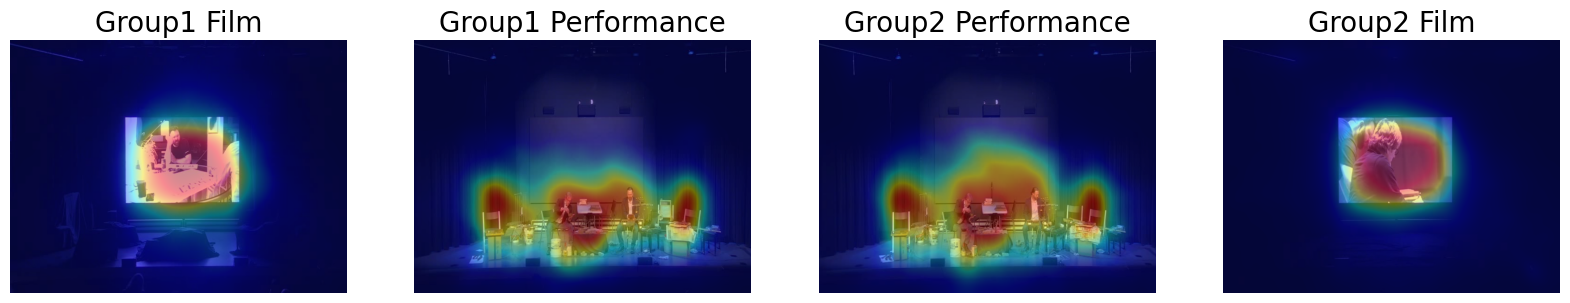

In [1046]:
fig, axs = plt.subplots(1,4, figsize=(20,4))
heatmaps_avg = {}
for i, (vals, df) in enumerate(hom_gaze.groupby(["Day", "Medium"])):
    if i in (2, 3):
        i = 5 - i #reverse order for day 2
    heatmap_avg = df["Heatmap"].mean(axis=0)
    if vals[1] == "performance":
        heatmaps_avg[f"Day {vals[0]} {vals[1]}"] = heatmap_avg
    #display ref image in background
    bg = cv2.imread(f"Day {vals[0]} {vals[1]} ref.png".replace(" ", "_"))
    bg = cv2.resize(bg, (640,480))
    axs[i].imshow(bg[:,:,::-1])
    #Overlay with heatmap
    axs[i].imshow(plot_heatmap(heatmap_avg)[:,:,::-1], alpha = 0.4)
    axs[i].set_title(f"Group{vals[0]} {vals[1].capitalize()}", fontsize=20)
    axs[i].set_axis_off()
plt.savefig("plt_dumps/heatmaps_homography_avg.png", dpi=300, bbox_inches="tight")

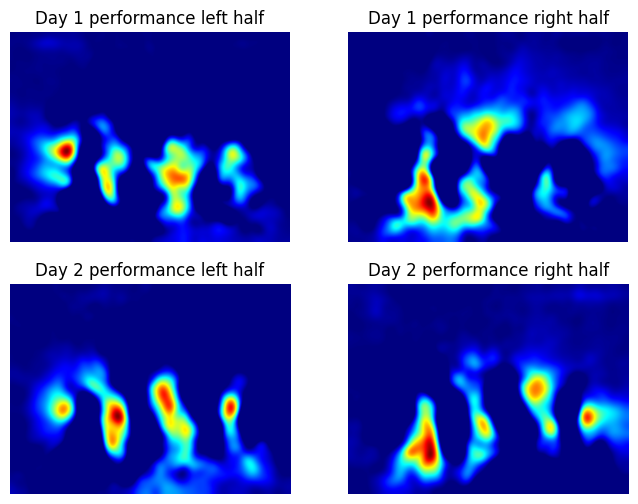

In [1202]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
for i, (k, v) in enumerate(heatmaps.items()):
    cond = k.rsplit(" ",2)[0]
    subt_heatmap = np.clip(heatmaps_avg[cond] - v, 0, None)
    axs[i//2][i%2].imshow(plot_heatmap(subt_heatmap)[:,:,::-1])
    axs[i//2][i%2].set_title(k)
    axs[i//2][i%2].set_axis_off()

Entropy and Velocity

In [21]:
hom_gaze[["Day", "Medium", "Entropy", "Velocity"]].groupby(["Day", "Medium"]).describe()

Entropy                                                    \
                  count      mean       std       min       25%       50%   
Day Medium                                                                  
1   film           30.0  0.762375  0.032772  0.711963  0.741916  0.757821   
    performance    29.0  0.819700  0.029215  0.779780  0.796561  0.808227   
2   film           30.0  0.771568  0.027014  0.723709  0.751823  0.765569   
    performance    30.0  0.830203  0.026245  0.777685  0.814727  0.820623   

                                    Velocity                                  \
                      75%       max    count       mean       std        min   
Day Medium                                                                     
1   film         0.777519  0.848641     30.0  22.992322  7.255275  10.735179   
    performance  0.844155  0.890090     29.0  16.758093  6.791462   9.280873   
2   film         0.789419  0.838007     30.0  35.999471  5.896339  26.123186   
    performance  0.846469  0.885188     30.0  22.107010  8.025795   9.632949   

                                                             
                       25%        50%        75%        max  
Day Medium                                                   
1   film         17.496566  22.653049  28.271186  38.702367  
    performance  11.670488  13.578030  21.718819  31.765467  
2   film         30.601790  35.449795  41.024946  46.253612  
    performance  17.595289  18.811065  28.168332  43.714794

In [1057]:
{k.split("_")[1]+("ormance" if k.split("_")[1]=="perf" else ""):v for k,v in groups_palette.items() if k[3]=="1"}

{'film': '#c7295a', 'performance': '#DB9D35'}

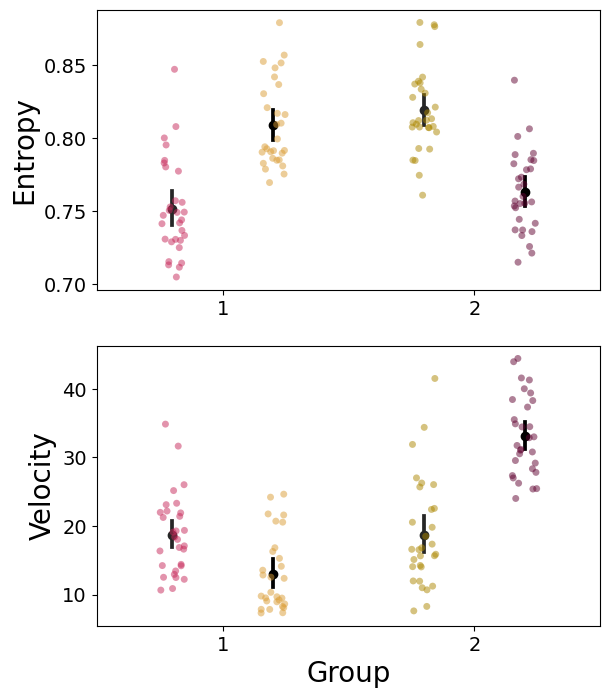

In [1066]:
fig, axs = plt.subplots(2,1, figsize = (6.5,8))

for i, measure in enumerate(["Entropy", "Velocity"]):
    for day, order in enumerate([['film', 'performance'], ['performance', 'film']]):
        if i==1 and day==0:
            show_legend = True
        else:
            show_legend = False
        
            
        sns.stripplot(
            data=hom_gaze[hom_gaze["Day"]== str(day+1)], x = "Day", hue="Medium", y=measure,
            dodge=True, alpha=.5 , legend=False, ax = axs[i], hue_order = order, 
            palette = {k.split("_")[1]+("ormance" if k.split("_")[1]=="perf" else ""):v for k,v in groups_palette.items() if k[3]==str(day+1)}) 
        
        sns.pointplot(
            data=hom_gaze[hom_gaze["Day"]== str(day+1)], x = "Day", hue="Medium", y=measure,
            linestyle="none", errorbar="ci", dodge=.4, hue_order = order,
            marker=".", markersize=10, markeredgewidth=2, alpha = 1, ax = axs[i], legend = False, color="black") 
    
    axs[i].set_ylabel(measure, fontsize=20)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    if i==1:
        axs[i].set_xlabel("Group", fontsize=20)
    else:
        axs[i].set_xlabel("", fontsize=14)

plt.savefig("plt_dumps/gaze_measures_homography.png", dpi=300, bbox_inches='tight')
# plt.show()

#### Temporal measures

In [ ]:
def process_df(df, suff):
    """Replaces invalid values with NAN and renames columns"""
    df = df[["timestamp [ns]", "transformed_gaze_x", "transformed_gaze_y"]]
    df["transformed_gaze_x"] = df["transformed_gaze_x"].apply(lambda x: x if x in range(0,641) else np.nan)
    df["transformed_gaze_y"] = df["transformed_gaze_y"].apply(lambda y: y if y in range(0,481) else np.nan)
    df = df.rename(columns = {"transformed_gaze_x":f"transformed_gaze_x_{suff}",
                            "transformed_gaze_y":f"transformed_gaze_y_{suff}"}) #8 and 4 are hardset for the current file naming scheme
    return df

merged_dfs = {}
for day in range(1,3):
    for medium in ["film", "performance"]:
        print(f"Day {day} {medium}")
        hom_paths = glob.glob(os.path.join(DATA_PATH, f"EventDay{day}/HomographyResults_{medium}/transformed_gaze_G???.csv"))
        for i,path in tqdm(enumerate(hom_paths)):
            if i==0:
                merged_df = pd.read_csv(path)
                merged_df = process_df(merged_df, path[-8:-4])
            else:
                df = pd.read_csv(path)
                df = process_df(df, path[-8:-4]) #8 and 4 are hardset for the current file naming scheme
                merged_df = pd.merge_asof(merged_df.sort_values("timestamp [ns]"), df.sort_values("timestamp [ns]"), 
                                          on="timestamp [ns]")
        merged_df["timestamp_ltz"] = pd.to_datetime(merged_df["timestamp [ns]"], unit="ns", utc=True)
        #number of gaze points out of frame at each timepoint
        merged_df["x_isna"] = merged_df[[c for c in merged_df.columns if "_x_" in c]].isna().sum(axis=1) 
        merged_df["y_isna"] = merged_df[[c for c in merged_df.columns if "_y_" in c]].isna().sum(axis=1)
        #mean of x and y cords from all participants
        merged_df["mean_x"] = merged_df[[c for c in merged_df.columns if "_x_" in c]].mean(axis=1) #skipna=True by default
        merged_df["mean_y"] = merged_df[[c for c in merged_df.columns if "_y_" in c]].mean(axis=1)
        #std of all x and y cords at given timepoint
        merged_df["std_x"] = merged_df[[c for c in merged_df.columns if "_x_" in c]].std(axis=1) 
        merged_df["std_y"] = merged_df[[c for c in merged_df.columns if "_y_" in c]].std(axis=1) 
        merged_dfs[f"Day {day} {medium}"] = merged_df

In [ ]:
#Convex Hull Area is an operational definition of dispersion as the smallest convex 
# polygon containing set of data samples. The convex hull area was adapted to eye 
# tracking analysis by Goldberg & Kotval (1999). 

In [ ]:
def convex_hull(row):
    """Process row to calculate a convex hull and return perimeter and area of the hull"""
    pts = []
    for i in range(1,31):
        device = "G"+str(i).zfill(3)
        try:
            pt_x = row["transformed_gaze_x_"+device]
            pt_y = row["transformed_gaze_y_"+device]
            if pd.notna(pt_x) and pd.notna(pt_y):
                pts.append([pt_x,pt_y])
        except:
            pass
    if len(pts) > 2:
        hull = ConvexHull(pts)
        return hull.area, hull.volume, len(pts)
    else:
        return np.nan, np.nan, len(pts)

for cond, merged_df in merged_dfs.items():
    print(cond)
    for i,row in tqdm(merged_df.iterrows()):
        perimeter, area, pts_in_frame = convex_hull(row)
        merged_df.at[i, "convex_peri"] = perimeter
        merged_df.at[i, "convex_area"] = area
        merged_df.at[i, "pts_in_frame"] = pts_in_frame

In [14]:
#Min max normalize convex area
for merged_df in merged_dfs.values():
    merged_df.convex_area = (merged_df.convex_area-merged_df.convex_area.min())/(merged_df.convex_area.max()-merged_df.convex_area.min())

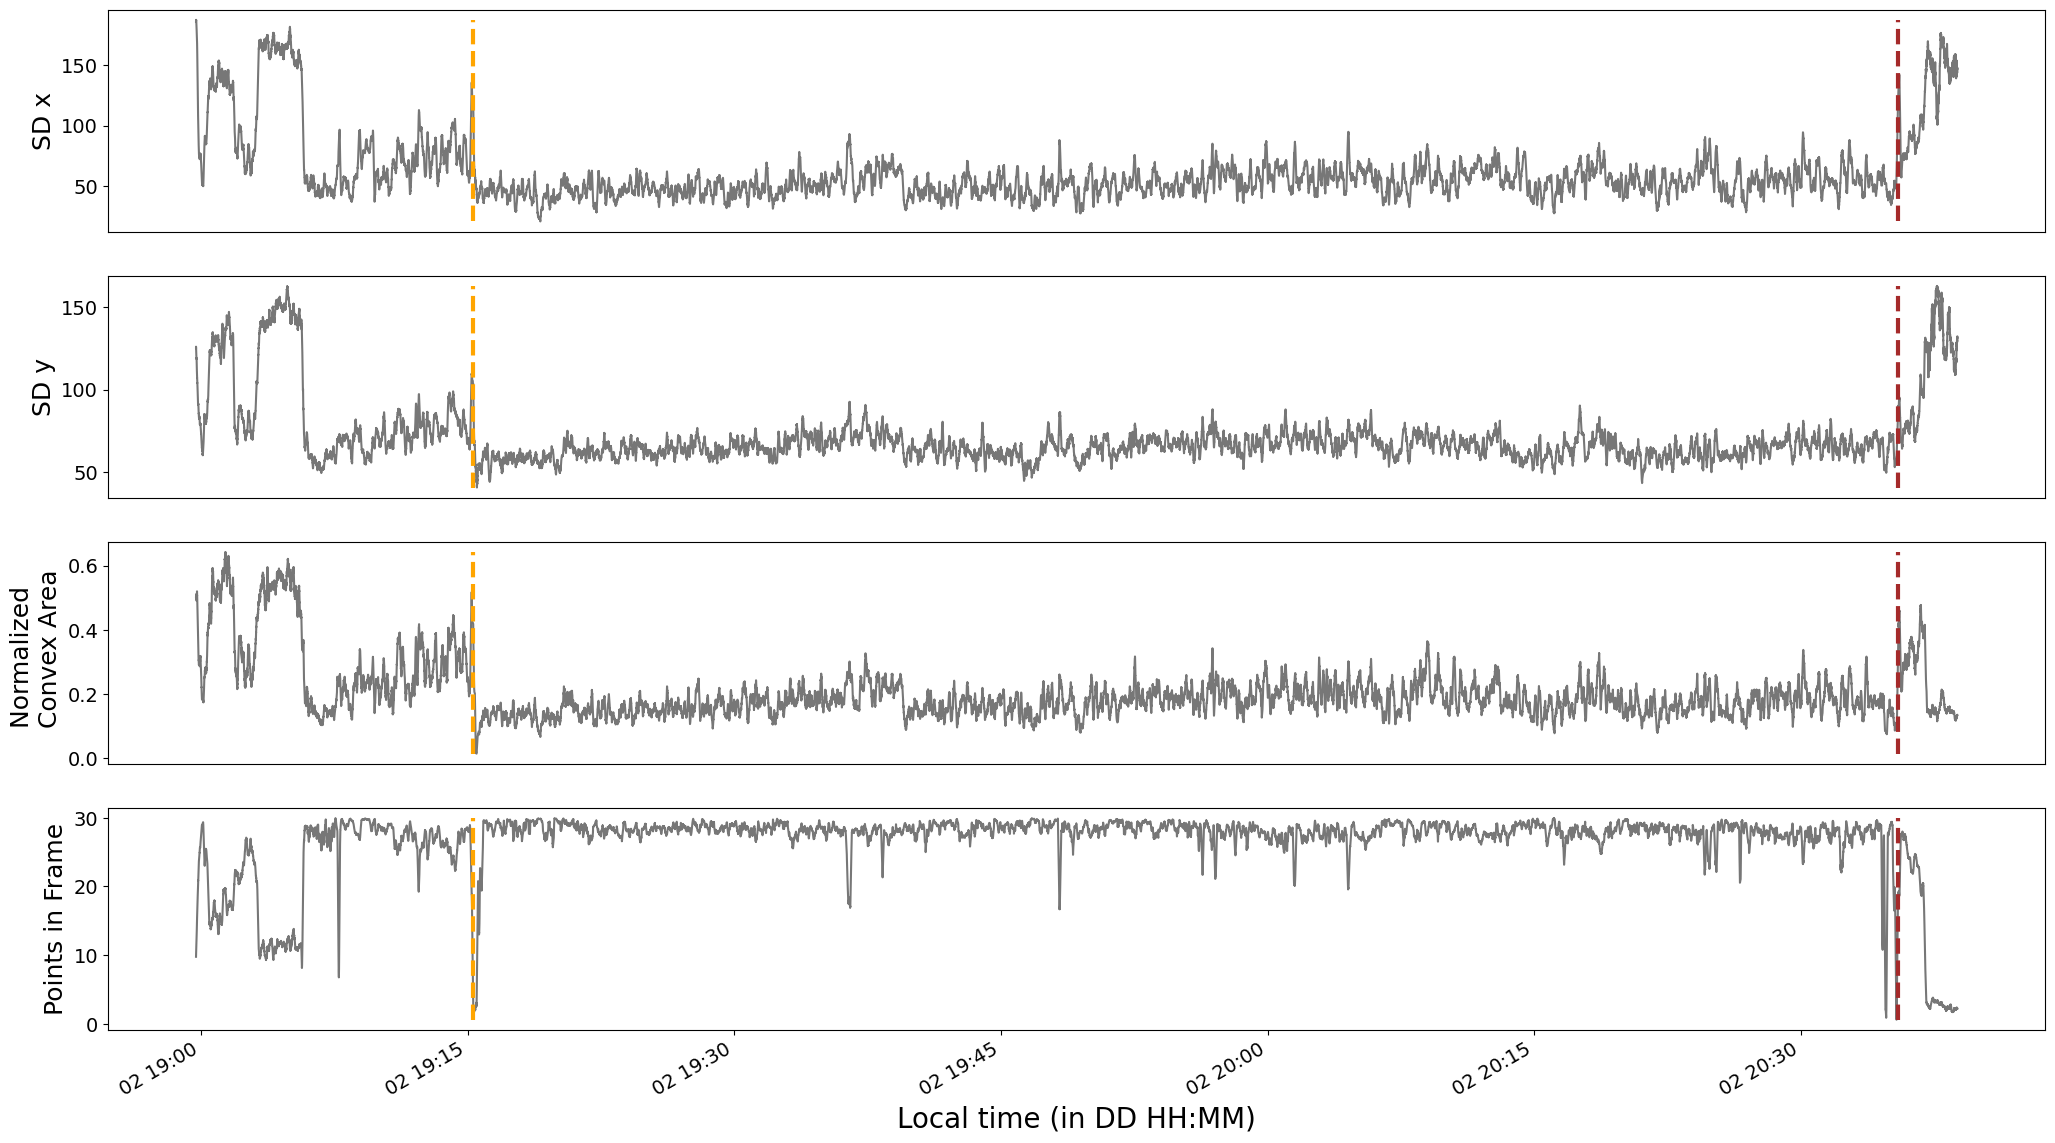

In [1186]:
## Plot timeseries of joint gaze measures during day1 film session

fig, axs = plt.subplots(4, 1, figsize=(25, 15))
cols = ["orange", "brown"]
for i, (measure, lbl) in enumerate({'std_x': "SD x", 'std_y': "SD y", 'convex_area': "Normalized \n Convex Area", 'pts_in_frame': "Points in Frame"}.items()):
    sub_df = merged_dfs["Day 1 film"].set_index("timestamp_ltz")[measure].dropna().rolling(150).mean()
    sub_df.plot(ax=axs[i], color="#777777")
    axs[i].set_ylabel(lbl, fontsize=18)
    axs[i].vlines(list(event_timestamps["day1"]["film"].values()), ymin = sub_df.min(), ymax = sub_df.max(), colors = cols, linestyles = "--", lw = 3)
    if i < 3:
        axs[i].set_xticks([])
        axs[i].set_xlabel("")
    else:
        axs[i].set_xlabel("Local time (in DD HH:MM)", fontsize=20)
    axs[i].tick_params(axis="both", labelsize=14)
plt.savefig("plt_dumps/temporal_day1_film.png", dpi=300, bbox_inches='tight')

In [1196]:
starts_df = events_df[~events_df["Label"].str.contains("End")]
starts_df = pd.concat([starts_df, events_df.iloc[-1:,:]]).reset_index(drop=True) #add last tableau end == performance end
starts_df

No                         Label       Medium   Detail Day1_VideoTimecode  \
0    7     Performers_Going_To_Stage  Performance      NaN        03:57:57:38   
1    8               01_Prolog_Start  Performance  Tableau        03:58:19:45   
2   10                02_Marse_Start  Performance  Tableau        03:59:57:50   
3   12            03_Intro-Rap_Start  Performance  Tableau        04:03:07:20   
4   14           04_Exposition_Start  Performance  Tableau        04:03:45:10   
5   16        05_Interrogation_Start  Performance  Tableau        04:06:28:45   
6   18        06_Justice-Truth_Start  Performance  Tableau        04:15:18:45   
7   20  07_CognitiveDissonance_Start  Performance  Tableau        04:20:18:30   
8   22            08_MbiraSong_Start  Performance  Tableau        04:23:17:00   
9   24         09_Litany-Rocks_Start  Performance  Tableau        04:26:53:00   
10  26         10_Lineup-Canjo_Start  Performance  Tableau        04:32:10:00   
11  28    11_PodRattleIncident_Start  Performance  Tableau        04:35:34:00   
12  30             12_Meantime_Start  Performance  Tableau        04:37:14:30   
13  32               13_IAmJax_Start  Performance  Tableau        04:39:47:00   
14  34           14_BehindBars_Start  Performance  Tableau        04:43:06:00   
15  36           15_Time-Truth_Start  Performance  Tableau        04:47:25:00   
16  38          16_TearingItUp_Start  Performance  Tableau        04:53:23:30   
17  40   17_Survivors-Postlude_Start  Performance  Tableau        04:57:48:00   
18  41     17_Survivors-Postlude_End  Performance  Tableau        04:59:16:00   

   Day2_VideoTimecode Day1_ActualTime Day2_ActualTime  
0         02:09:38:00             NaN             NaN  
1         02:10:06:15             NaN             NaN  
2         02:11:46:25             NaN             NaN  
3         02:14:56:55             NaN             NaN  
4         02:15:36:45             NaN             NaN  
5         02:18:31:30             NaN             NaN  
6         02:27:33:00             NaN             NaN  
7         02:33:03:00             NaN             NaN  
8         02:36:22:15             NaN             NaN  
9         02:40:04:00             NaN             NaN  
10        02:45:20:00             NaN             NaN  
11        02:48:50:30             NaN             NaN  
12        02:50:32:00             NaN             NaN  
13        02:53:23:00             NaN             NaN  
14        02:57:14:00             NaN             NaN  
15        03:02:04:00             NaN             NaN  
16        03:07:43:30             NaN             NaN  
17        03:12:20:45             NaN             NaN  
18        03:13:44:00             NaN             NaN

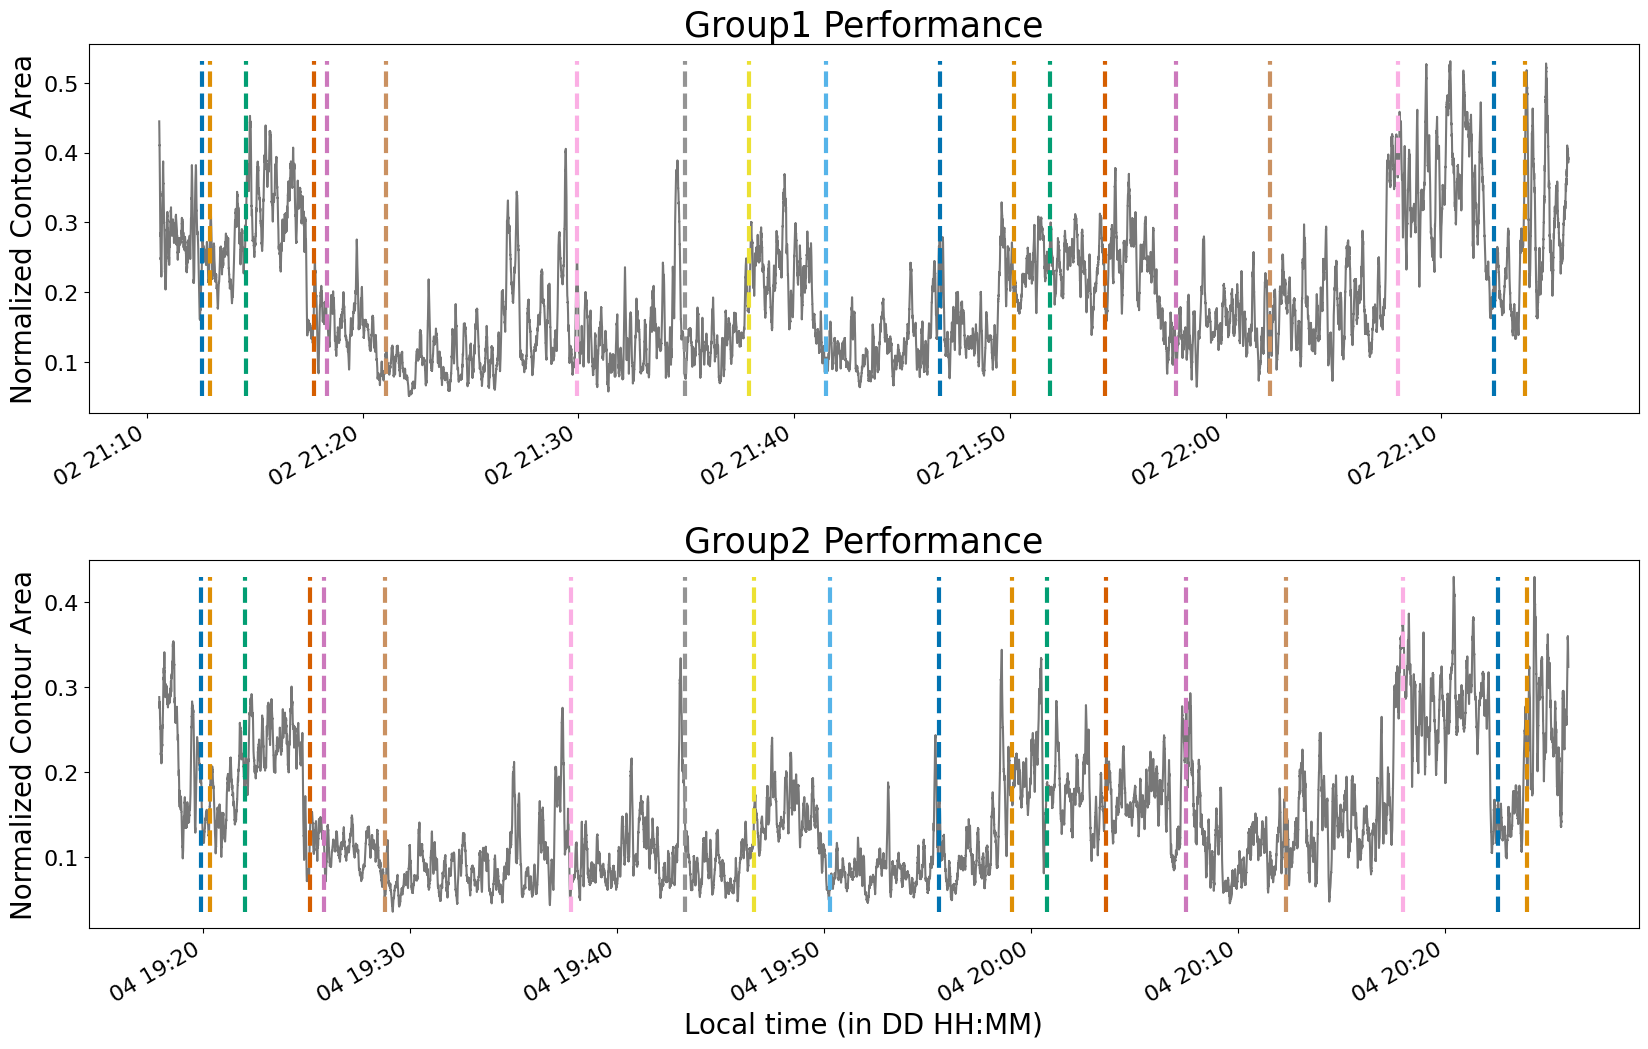

In [1298]:
#Plot timeseries of Contour Area during performance sessions

fig, axs = plt.subplots(2,1, figsize=(20,13))
fig.subplots_adjust(hspace=0.4)
colors = sns.color_palette("colorblind", len(day1_jatos[day1_jatos["msg"] == "start_tab"]))\

sub_dict = {k:v for k,v in merged_dfs.items() if "performance" in k}
for i, (cond, merged_df) in enumerate(sub_dict.items()):
    sub_df = merged_df.set_index("timestamp_ltz")["convex_area"].dropna().rolling(150).mean()
    day, session = cond.split(" ")[-2:]
    #trim between performance start timestamp from JATOS to end of last tabeau with 2 minutes buffer on each end
    start_ts = event_starts_alex["day"+day].iloc[0] - timedelta(minutes=2)
    end_ts = event_starts_alex["day"+day].iloc[-1] + timedelta(minutes=2)
    sub_df = sub_df[(start_ts<=sub_df.index) & (sub_df.index<=end_ts)]

    #trim_df
    # trim_merged_df = merged_df[(merged_df['timestamp_ltz']>=sub_df.index.min())& (merged_df['timestamp_ltz']<=sub_df.index.max())]
    # cols = [col for col in trim_merged_df.columns if "transformed_gaze_x" in col]
    # blink_probs = trim_merged_df[cols].isna().sum(axis=1)/len(cols)
    # blink_probs.plot(ax = axs[i], color="#110000")
    
    #plot the trimmed data
    sub_df.plot(ax = axs[i], color="#777777")
    axs[i].set_title(cond.title().replace("Day ", "Group"), fontsize=25)
    axs[i].tick_params(axis='both', labelsize=16)
    if i==0:
        axs[i].set_xlabel("")
    else:
        axs[i].set_xlabel("Local time (in DD HH:MM)", fontsize=20)
    axs[i].set_ylabel("Normalized Contour Area", fontsize=20)

    #display start tab lines
    
    axs[i].vlines(event_starts_alex["day"+day], ymin = sub_df.min(), ymax = sub_df.max(), colors = colors, linestyles = "--", lw=3)
    # axs[i].vlines(timestamps_en, ymin = sub_df.min(), ymax = sub_df.max(), colors = "green", linestyles = "--")
plt.savefig("plt_dumps/performance_temporal_measures.png", bbox_inches="tight", dpi=300)

In [449]:
day1_df = sub_dict["Day 1 performance"][["timestamp_ltz", "convex_area"]]
day2_df = sub_dict["Day 2 performance"][["timestamp_ltz", "convex_area"]]
sim_cc = np.zeros((19, 19))
sim_dtw = np.zeros((19,19))

for i in trange(1,19):
    day1_t0 = event_starts_alex["day1"][i-1]
    day1_t1 = event_starts_alex["day1"][i]
    sub_day1 = day1_df[(day1_t0 <= day1_df["timestamp_ltz"]) & (day1_df["timestamp_ltz"] <= day1_t1)]

    for j in trange(i,19, leave=False):
        day2_t0 = event_starts_alex["day2"][j-1]
        day2_t1 = event_starts_alex["day2"][j]
        sub_day2 = day2_df[(day2_t0 <= day2_df["timestamp_ltz"]) & (day2_df["timestamp_ltz"] <= day2_t1)]
    
        sim_dtw[i][j] = dtw(sub_day1["convex_area"], sub_day2["convex_area"])
        sim_cc[i][j] = sub_day1["convex_area"].reset_index(drop=True).corr(sub_day2["convex_area"].reset_index(drop=True))

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

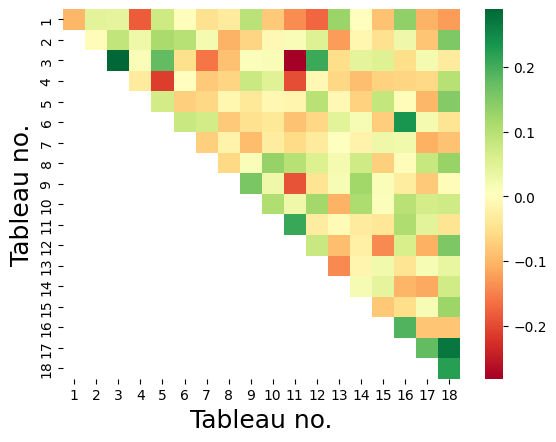

In [1173]:
# Plot similarity of eye movements between tableau
sns.heatmap(sim_cc[1:, 1:], cmap="RdYlGn",xticklabels=range(1,19), yticklabels=range(1,19))
plt.savefig("plt_dumps/tableau_similarity.png", bbox_inches="tight", dpi=300)
plt.tick_params(axis='both', labelsize=10)
plt.xlabel("Tableau no.", fontsize=18)
plt.ylabel("Tableau no.", fontsize=18)
plt.savefig("plt_dumps/performance_temporal_matrix.png", bbox_inches="tight", dpi=300)

In [1175]:
df = pd.DataFrame(columns = ["Tableau no.", "Day", "Mean", "Std", "ts"])
for i in trange(1,19):
    for day in trange(1,3, leave=False):
        t0 = event_starts_alex[f"day{day}"][i-1]
        t1 = event_starts_alex[f"day{day}"][i]
        measure_df = sub_dict[f"Day {day} performance"][["timestamp_ltz", "convex_area"]] #can use any other measure as well
        measure_df = measure_df[(t0 <= measure_df["timestamp_ltz"]) & (measure_df["timestamp_ltz"] <= t1)] #trim measure timeseries between tableau start and end
        df.loc[df.shape[0]] = {"Tableau no.": i, "Day": day, "Mean": measure_df.convex_area.mean(), "Std": measure_df.convex_area.std(), "ts": measure_df.convex_area}

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

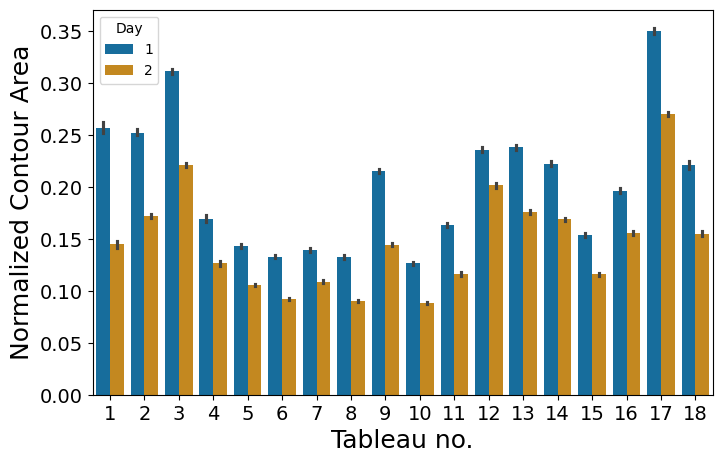

In [1180]:
plt.figure(figsize=(8,5))
sns.barplot(df.explode("ts"), x="Tableau no.", y="ts", hue="Day", errorbar="ci", palette=sns.color_palette("colorblind"))
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("Tableau no.", fontsize=18)
plt.ylabel("Normalized Contour Area", fontsize=18)
plt.savefig("plt_dumps/tableau_similarity2.png", bbox_inches="tight", dpi=300)

## Blinks

In [1089]:
blinks_dfs = glob.glob(os.path.join(DATA_PATH, "EventDay?/Eyes/CompanionDevices/*.*.*.*/Neon/b5b4*/*/export_PLCloud/*/blinks.csv"))
aggr_blink_df = pd.DataFrame()
for path in tqdm(blinks_dfs):
    try:
        ip = re.findall(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', path)[0]
        day, event = re.findall(r'day(.)_(.*?)/', path)[0]
    except Exception as e:
        print(r, "Re match failed")
    blink_df = pd.read_csv(path)
    blink_df["device"] = ip
    blink_df["day"] = day
    blink_df["event"] = event
    blink_df["condition"] = f"Day {day} {event}"
    blink_df["inter_blink_time"] = blink_df["start timestamp [ns]"] - blink_df["end timestamp [ns]"].shift(1)
    blink_df["inter_blink_time"] = blink_df["inter_blink_time"]/1e3 #convert to ms
    aggr_blink_df = pd.concat([aggr_blink_df, blink_df.sort_values("start timestamp [ns]")], ignore_index=True)

  0%|          | 0/120 [00:00<?, ?it/s]

In [1090]:
aggr_blink_df["start_time"] = pd.to_datetime(aggr_blink_df["start timestamp [ns]"], unit="ns", utc=True)
aggr_blink_df["end_time"] = pd.to_datetime(aggr_blink_df["end timestamp [ns]"], unit="ns", utc=True) #.dt.tz_convert("") to localize timestamps

In [1091]:
aggr_blink_df.columns

Index(['section id', 'recording id', 'blink id', 'start timestamp [ns]',
       'end timestamp [ns]', 'duration [ms]', 'device', 'day', 'event',
       'condition', 'inter_blink_time', 'start_time', 'end_time'],
      dtype='object')

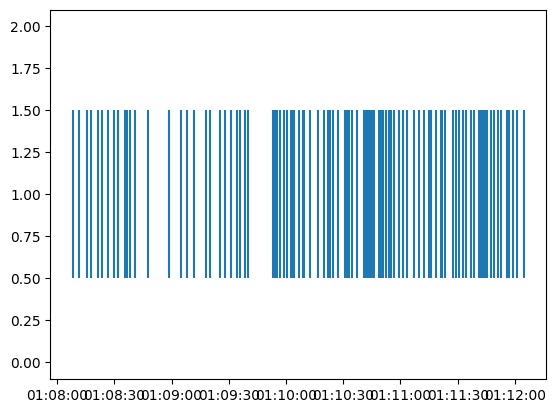

In [628]:
#RASTER PLOT: Single device blink start times (too long to display in one plot)
plt.eventplot(aggr_blink_df[aggr_blink_df.device == "192.168.35.151"]["start_time"][:100].values)

In [ ]:
df['timestamp'] = df['timestamp'].replace(pd.NaT, np.nan)

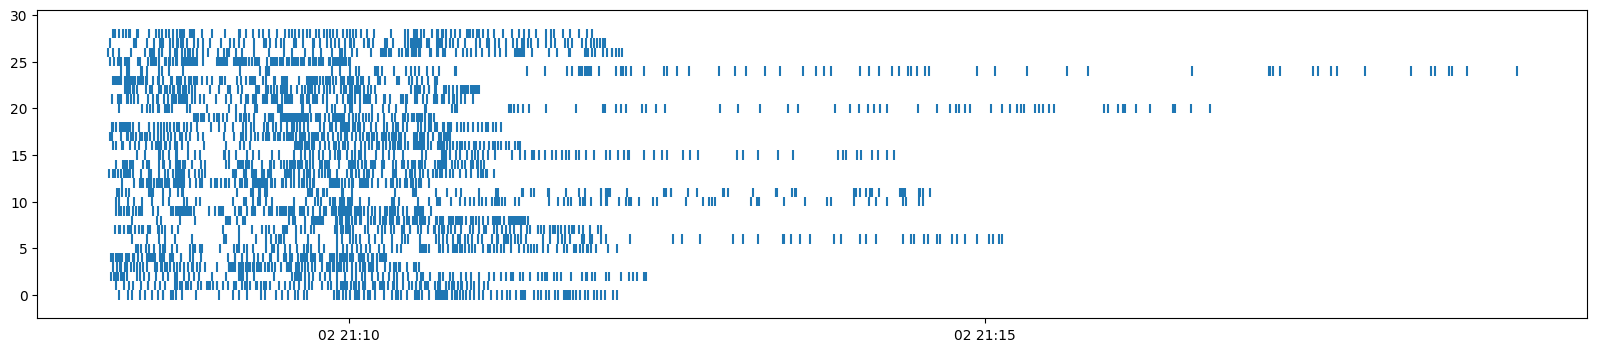

In [663]:
plt.figure(figsize=(20,4))
plt.eventplot(df[:,:100])

plt.show()

Interesting that the blink frequency is so different for different participants. 

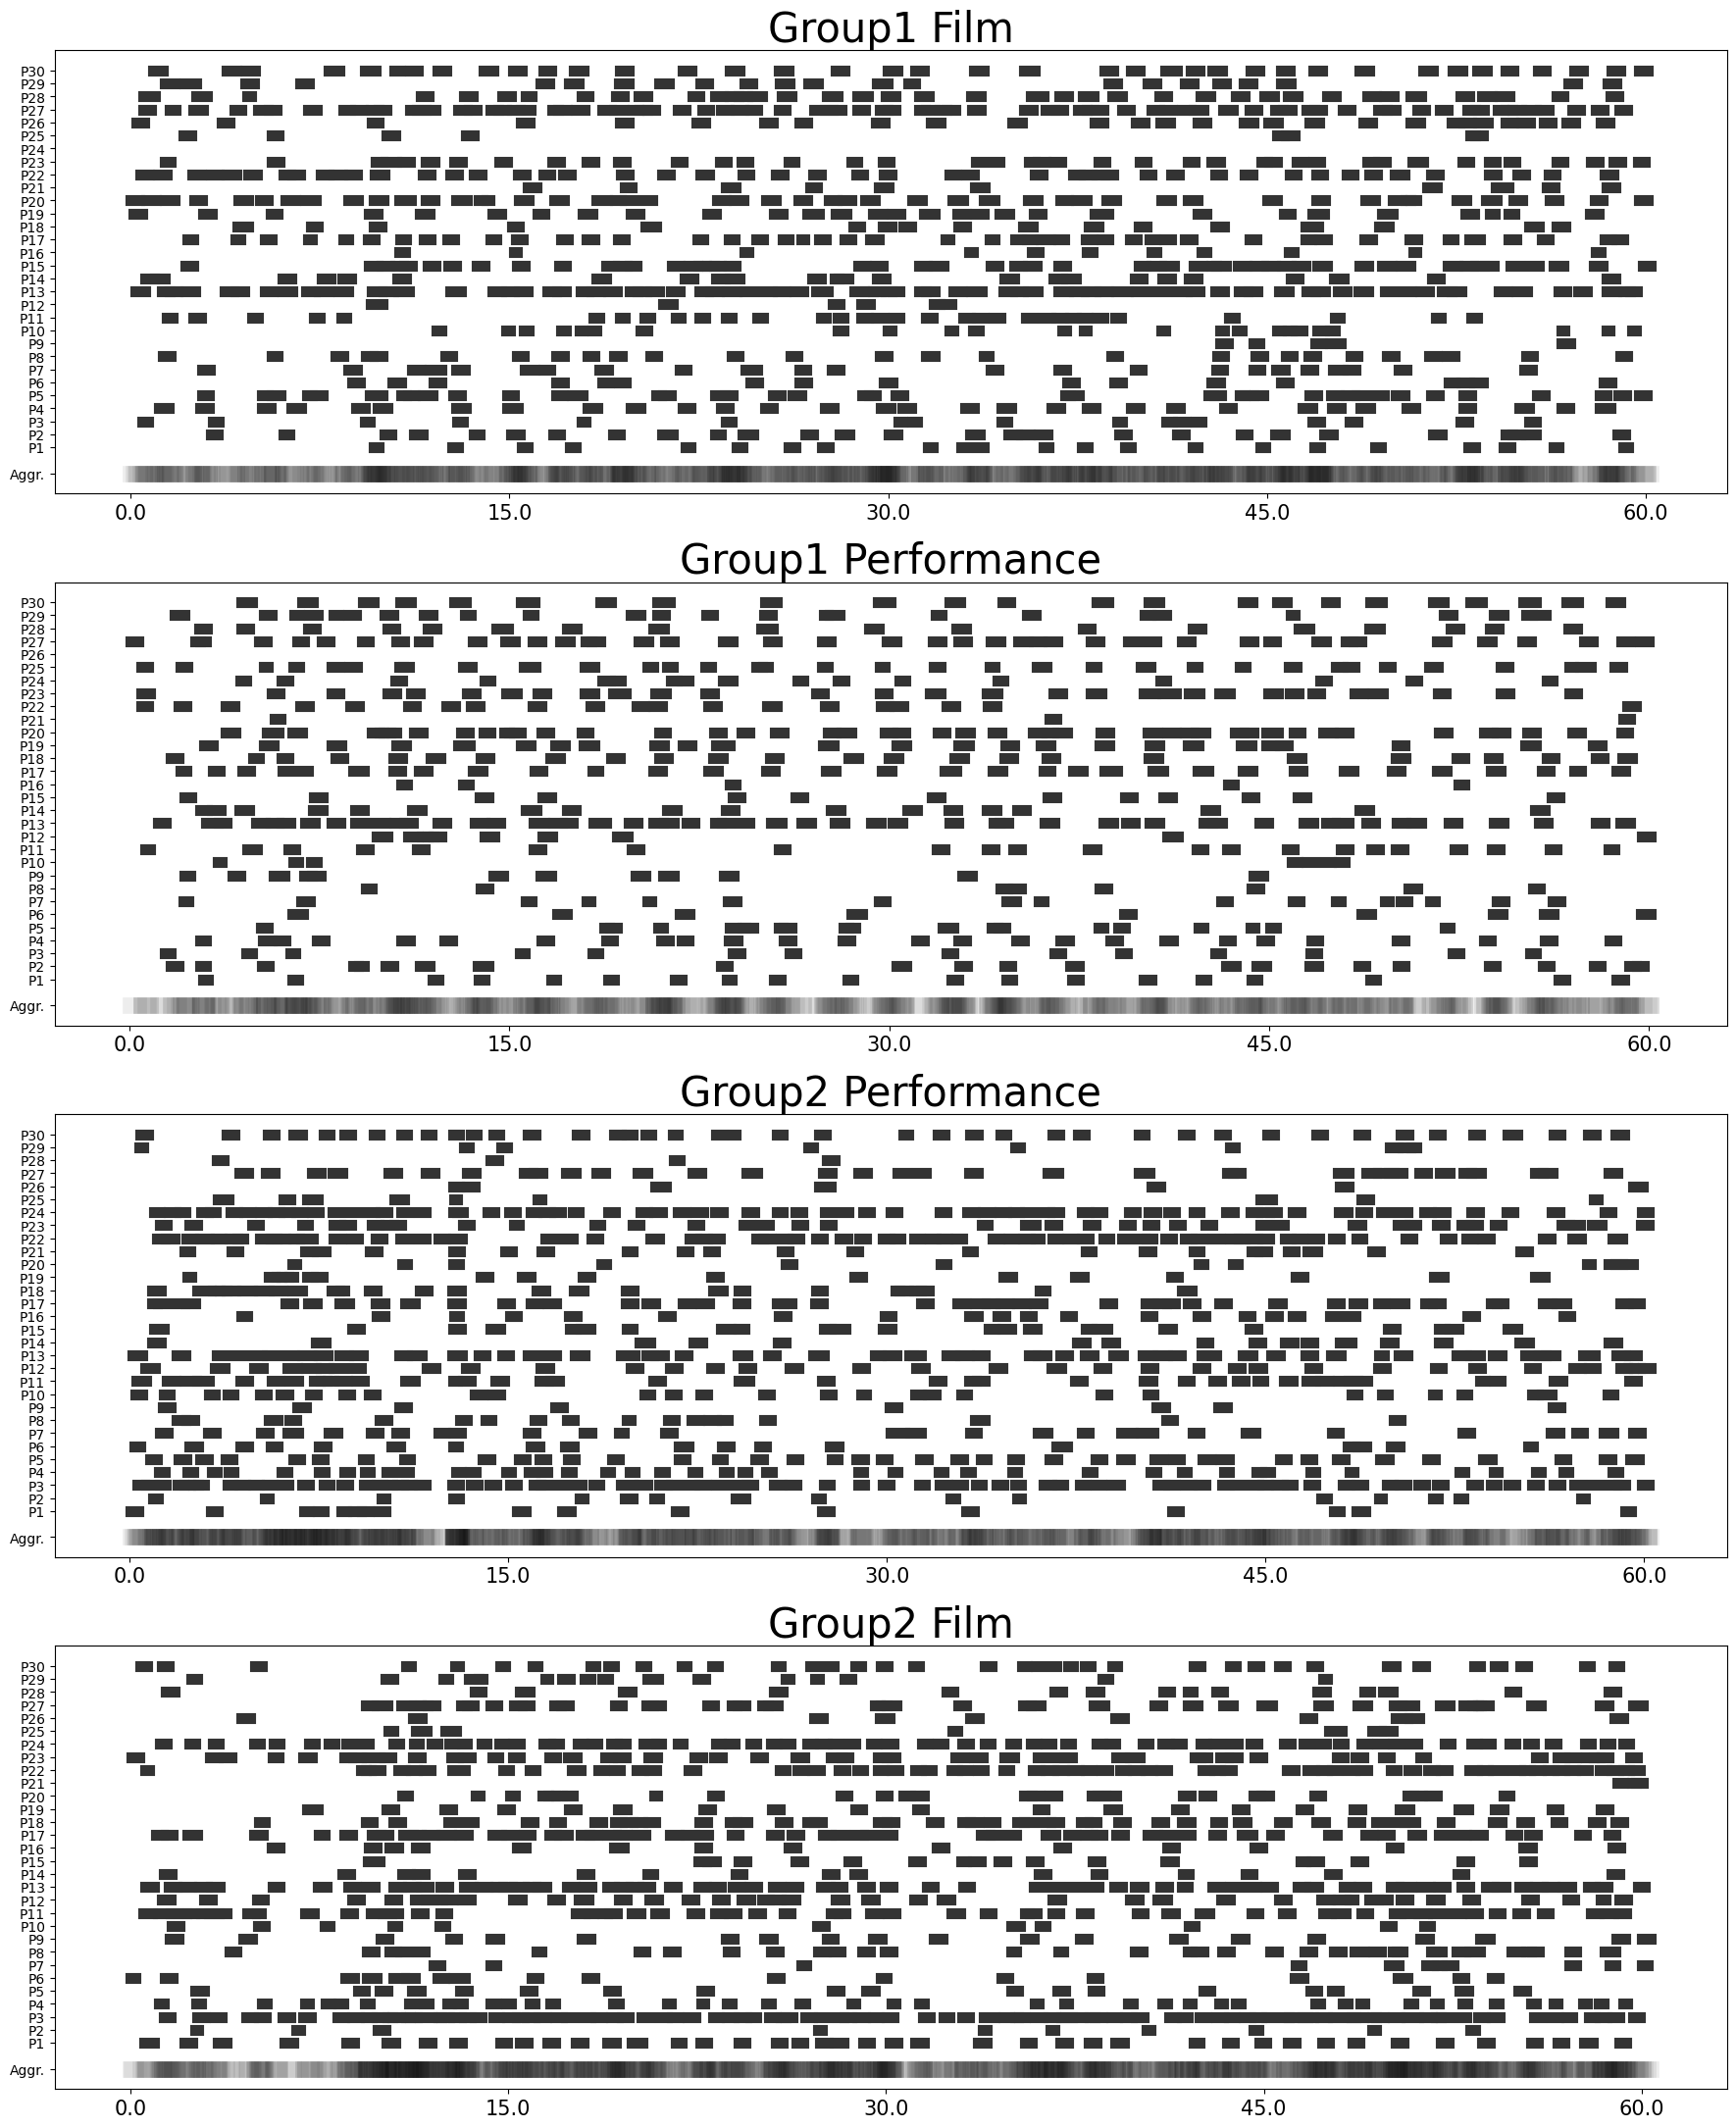

In [1144]:
#visualise blinks as overlaping bars, like a Gantt chart 
fig, axs = plt.subplots(4, 1, figsize=(22,27))

for i, (vals, df) in enumerate(aggr_blink_df.groupby(["day", "event"])):
    if i in [2,3]:
        i=5-i #reverse order for day 2

    #create gantt plot for first n seconds
    t0 = event_timestamps[f"day{vals[0]}"][vals[1]]["start"] + datetime.timedelta(minutes=30)
    t1 = t0 + datetime.timedelta(seconds = 60)
    for _, row in df.iterrows():
        if  t0 < row["start_time"] < t1:
            dev_n = int(row["device"].split(".")[-1])-150
            axs[i].plot([row['start_time'], row['end_time']], [dev_n+1, dev_n+1], color='#333333', linewidth=8, alpha = 1)
            axs[i].plot([row['start_time'], row['end_time']], [0, 0], color='black', linewidth=12, alpha = 0.07)
    axs[i].set_title(f"Group{vals[0]} {vals[1].capitalize()}", fontsize=30)
    axs[i].set_yticks([0]+list(range(2, 32)), ["Aggr."] +["P"+str(i+1) for i in range(30)], fontsize=10)

    timestamps_x = pd.to_datetime(np.linspace(t0.value, t1.value, 5))
    axs[i].set_xticks(timestamps_x, [(x-timestamps_x[0]).total_seconds() for x in timestamps_x], fontsize=15)
    # device_name = "G"+str(int(row["device"].split(".")[-1])-150).zfill(3)

plt.savefig("plt_dumps/blinks_timeline.png", dpi=300, bbox_inches='tight')